In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import cartopy.crs as ccrs

import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns

import kinesis as kn
import gapipes as gp

plt.style.use('smoh')

In [2]:
%store -r out_full
d = out_full.loc[out_full['Member_r19'] != 'other']

In [52]:
df = {}  # data prepared for fitting

necessary_columns = [
    "ra",
    "dec",
    "phot_g_mean_mag",
    "parallax",
    "pmra",
    "pmdec",
    "parallax_error",
    "pmra_error",
    "pmdec_error",
    "parallax_pmra_corr",
    "parallax_pmdec_corr",
    "pmra_pmdec_corr",
]

df_leao_gaia_harps = (
    leao_gaia[necessary_columns]
    .assign(radial_velocity=leao_gaia["rv_harps"])
    .assign(radial_velocity_error=leao_gaia["erv_harps"])
).drop(index=46)
# index 46, hip 22271 is an obvious outlier, not particularly large chi2 from HG, not sure what to make of it.
df['leao_dr2_harps'] = df_leao_gaia_harps

df_leao_gaia_harps_frcor = df_leao_gaia_harps.copy()
df_leao_gaia_harps_frcor.g.correct_brightsource_pm()
df['leao_dr2_harps_frcor'] = df_leao_gaia_harps_frcor

In [53]:
df["leao_incl_outlier"] = (
    leao_gaia[necessary_columns]
    .assign(radial_velocity=leao_gaia["rv_harps"])
    .assign(radial_velocity_error=leao_gaia["erv_harps"])
)

In [5]:
df = pd.read_csv("../data/hyades_hgca_harps.csv", index_col=0)
df = df.rename(
    columns={
        "ra": "ra_leao",
        "dec": "dec_leao",
        "gaia_ra": "ra",
        "gaia_dec": "dec",
        "radial_velocity": "radial_velocity_gaia",
        "radial_velocity_error": "radial_velocity_error_gaia",
        "rv_harps": "radial_velocity",
        "erv_harps": "radial_velocity_error",
        "parallax_gaia": "parallax",
        "parallax_gaia_error": "parallax_error",
        "pmra_hg": "pmra",
        "pmdec_hg": "pmdec",
        "pmra_hg_error": "pmra_error",
        "pmdec_hg_error": "pmdec_error",
        "pmra_pmdec_hg": "pmra_pmdec_corr",
    }
)
df["parallax_pmra_corr"] = 0.0
df["parallax_pmdec_corr"] = 0.0
hy_harps_dr2 = df    # rename
print(f"number of sources in Leao selection: {len(hy_harps_dr2)} rows")

number of sources in Leao selection: 70 rows


In [6]:
hy_tgas = pd.read_csv("../data/reino_tgas_full.csv", index_col=0)
print(f"number of sources in Reino selection: {len(hy_tgas)} rows")

number of sources in Reino selection: 173 rows


In [7]:
s1 = set(hy_dr2["source_id"])
s2 = set(df["gaia_source_id"])
print(f"{len(s1 & s2)} in common")
print(f"{s2-s1}")

60 in common
{154257259425702144, 129070265532645888, 118234509720825856, 3313526556869575296, 117654650480415744, 11037726649058432, 48026706557926528, 45159901786525568, 3310500082395188224, 8479094371605632}


In [359]:
hy_tails_m19 = Table.read(
    "/home/soh/data/meingast2019_hyades_tails/hyades.dat",
    format="ascii.cds",
    readme="/home/soh/data/meingast2019_hyades_tails/ReadMe",
).to_pandas()
hy_tails_m19.columns = hy_tails_m19.columns.str.lower()
hy_tails_m19.rename(
    columns={
        "source": "source_id",
        "radeg": "ra",
        "dedeg": "dec",
        "plx": "parallax",
        "e_plx": "parallax_error",
        "pmde": "pmdec",
        "e_pmra": "pmra_error",
        "e_pmde": "pmdec_error",
        'rv':'radial_velocity',
        'e_rv':'radial_velocity_error'
    },
    inplace=True,
)

hy_tails_r19 = Table.read(
    "/home/soh/data/roeser_hyades_tails/stars.dat",
    format="ascii.cds",
    readme="/home/soh/data/roeser_hyades_tails/ReadMe",
).to_pandas()
hy_tails_r19.columns = hy_tails_r19.columns.str.lower()
hy_tails_r19.rename(
    columns={"source": "source_id", "radeg": "ra", "dedeg": "dec"}, inplace=True
)

print(f"Meingast N={len(hy_tails_m19):4d}")
print(f"Roeser   N={len(hy_tails_r19):4d}")

Meingast N= 238
Roeser   N=1316


Text(0, 0.5, 'RV HARPS - astrom. [km/s]')

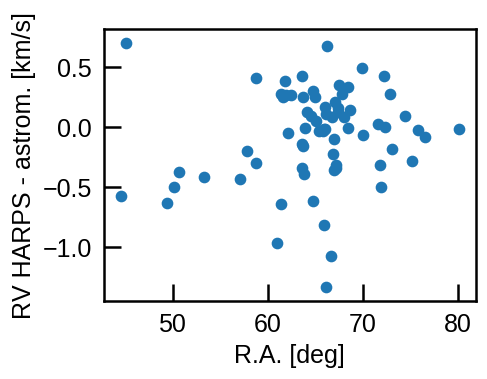

In [346]:
plt.figure(figsize=(4,3))
plt.scatter(df['ra'], df['drv_g17_gr+c+cr']/1e3)
plt.xlabel('R.A. [deg]')
plt.ylabel('RV HARPS - astrom. [km/s]')

Can R.A.-drv be due to wrong v0?

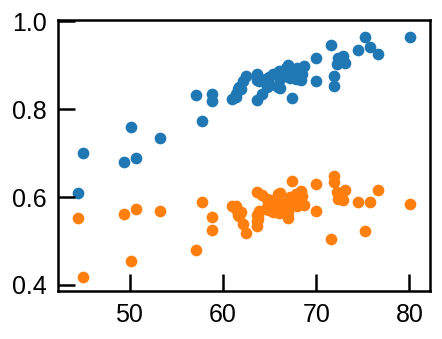

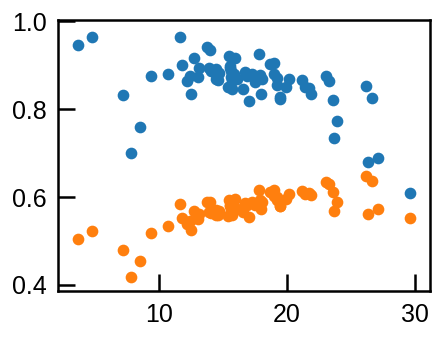

In [341]:
cl_a = kn.Cluster([-6.20, 45.43, 5.57], 0., b0=[0,0,0]).sample_at(df.g.icrs)
cl_b = kn.Cluster([-6.20, 46.43, 5.57], 0., b0=[0,0,0]).sample_at(df.g.icrs)
cl_c = kn.Cluster([-6.20, 45.93, 6.07], 0., b0=[0,0,0]).sample_at(df.g.icrs)

plt.figure(figsize=(4,3))
plt.scatter(df['ra'], cl_b.members.truth['radial_velocity'] - cl_a.members.truth['radial_velocity']);
plt.scatter(df['ra'], cl_c.members.truth['radial_velocity'] - cl_a.members.truth['radial_velocity']);

plt.figure(figsize=(4,3))
plt.scatter(df['dec'], cl_b.members.truth['radial_velocity'] - cl_a.members.truth['radial_velocity']);
plt.scatter(df['dec'], cl_c.members.truth['radial_velocity'] - cl_a.members.truth['radial_velocity']);

## Visualize residual velocity field

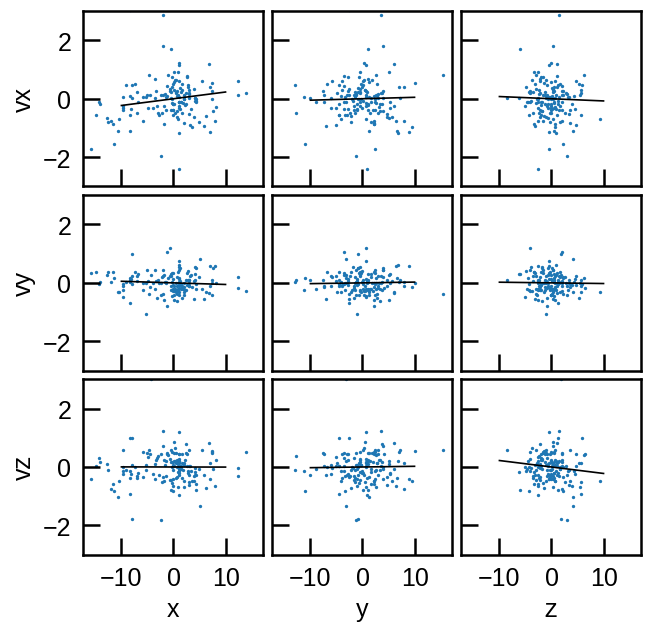

In [434]:
fig, ax = plt.subplots(3, 3, figsize=(6,6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=.05, hspace=.05)

# for dset in [hy_dr2, df['leao_dr2_harps']]:
for dset in [hy_dr2, ]:
    pos = dset.g.galactic.cartesian.xyz
    vel = dset.g.galactic.velocity.d_xyz
    relpos = pos - np.nanmedian(pos, axis=1)[:,None]
    relvel = vel - np.nanmedian(vel, axis=1)[:,None]

    ax[0,0].scatter(relpos[0], relvel[0], s=1)
    ax[1,0].scatter(relpos[0], relvel[1], s=1)
    ax[2,0].scatter(relpos[0], relvel[2], s=1)

    ax[0,1].scatter(relpos[1], relvel[0], s=1)
    ax[1,1].scatter(relpos[1], relvel[1], s=1)
    ax[2,1].scatter(relpos[1], relvel[2], s=1)

    ax[0,2].scatter(relpos[2], relvel[0], s=1)
    ax[1,2].scatter(relpos[2], relvel[1], s=1)
    ax[2,2].scatter(relpos[2], relvel[2], s=1)

for i, l in enumerate(['x','y','z']): ax[2,i].set_xlabel(l)
for i, l in enumerate(['vx','vy','vz']): ax[i, 0].set_ylabel(l)
    
mrT = rotate_T_to_galactic(stanfit['rvcleaned']['T_param']).mean(axis=0)
x=np.linspace(-10,10)
for i in range(3):
    for j in range(3):
        ax[i,j].plot(x, mrT[i,j]/1e3*x, c='k', lw=1)

for cax in ax.ravel(): cax.set_ylim(-3,3)

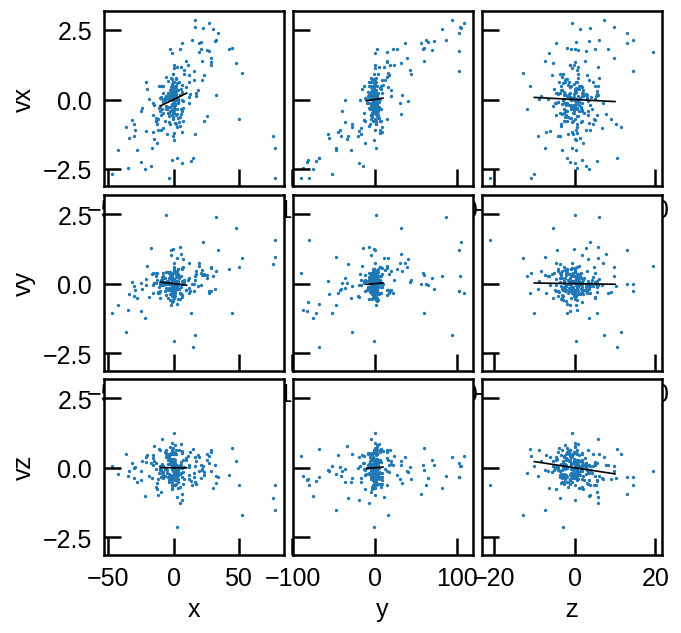

In [445]:
fig, ax = plt.subplots(3, 3, figsize=(6,6), sharex=False, sharey=True)
fig.subplots_adjust(wspace=.05, hspace=.05)

pos = hy_tails_m19.g.galactic.cartesian.xyz
vel = hy_tails_m19.g.galactic.velocity.d_xyz
relpos = pos - np.median(pos, axis=1)[:,None]
relvel = vel - np.median(vel, axis=1)[:,None]

ax[0,0].scatter(relpos[0], relvel[0], s=1)
ax[1,0].scatter(relpos[0], relvel[1], s=1)
ax[2,0].scatter(relpos[0], relvel[2], s=1)

ax[0,1].scatter(relpos[1], relvel[0], s=1)
ax[1,1].scatter(relpos[1], relvel[1], s=1)
ax[2,1].scatter(relpos[1], relvel[2], s=1)

ax[0,2].scatter(relpos[2], relvel[0], s=1)
ax[1,2].scatter(relpos[2], relvel[1], s=1)
ax[2,2].scatter(relpos[2], relvel[2], s=1)

mrT = rotate_T_to_galactic(stanfit['rvcleaned']['T_param']).mean(axis=0)
x=np.linspace(-10,10)
for i in range(3):
    for j in range(3):
        ax[i,j].plot(x, mrT[i,j]/1e3*x, c='k', lw=1)

for i, l in enumerate(['x','y','z']): ax[2,i].set_xlabel(l)
for i, l in enumerate(['vx','vy','vz']): ax[i, 0].set_ylabel(l)

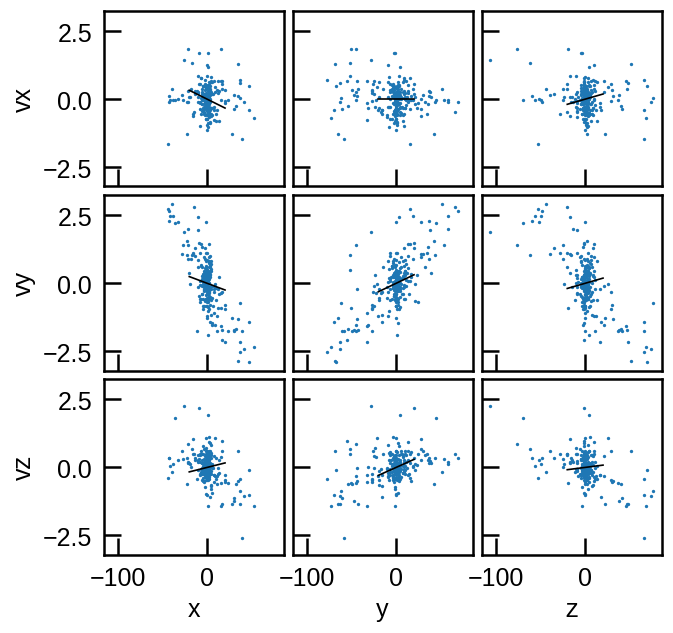

In [443]:
fig, ax = plt.subplots(3, 3, figsize=(6,6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=.05, hspace=.05)

pos = hy_tails_m19.g.icrs.cartesian.xyz
vel = hy_tails_m19.g.icrs.velocity.d_xyz
relpos = pos - np.median(pos, axis=1)[:,None]
relvel = vel - np.median(vel, axis=1)[:,None]

ax[0,0].scatter(relpos[0], relvel[0], s=1)
ax[1,0].scatter(relpos[0], relvel[1], s=1)
ax[2,0].scatter(relpos[0], relvel[2], s=1)

ax[0,1].scatter(relpos[1], relvel[0], s=1)
ax[1,1].scatter(relpos[1], relvel[1], s=1)
ax[2,1].scatter(relpos[1], relvel[2], s=1)

ax[0,2].scatter(relpos[2], relvel[0], s=1)
ax[1,2].scatter(relpos[2], relvel[1], s=1)
ax[2,2].scatter(relpos[2], relvel[2], s=1)


mrT = (stanfit['rvcleaned']['T_param']).mean(axis=0)
x=np.linspace(-20,20)
for i in range(3):
    for j in range(3):
        ax[i,j].plot(x, mrT[i,j]/1e3*x, c='k', lw=1)

for i, l in enumerate(['x','y','z']): ax[2,i].set_xlabel(l)
for i, l in enumerate(['vx','vy','vz']): ax[i, 0].set_ylabel(l)

# Fit

## Vanilla DR2 Gaia collaboration selection

In [4]:
necessary_columns = [
    "ra",
    "dec",
    "phot_g_mean_mag",
    "parallax",
    "pmra",
    "pmdec",
    "parallax_error",
    "pmra_error",
    "pmdec_error",
    "parallax_pmra_corr",
    "parallax_pmdec_corr",
    "pmra_pmdec_corr",
]

df_vanilla_dr2 = hy_dr2[
    necessary_columns + ["radial_velocity", "radial_velocity_error"]
]

In [5]:
%%time
m = kn.Fitter() #recompile=True)
b0 = np.median(hy_dr2.g.icrs.cartesian.xyz.value, axis=1)
print(f"b0 = {b0}")

INFO:kinesis.models:Reading model from disk


b0 = [17.26821532 41.64304963 13.606407  ]
CPU times: user 11.4 ms, sys: 3.23 ms, total: 14.6 ms
Wall time: 31.4 ms


In [6]:
stanfit = {}
azfit = {}

In [56]:
%%time
stanfit['vanilla'] = m.fit(df_vanilla_dr2, b0=b0, pars=None)
azfit['vanilla'] = az.from_pystan(stanfit['vanilla'])

CPU times: user 36.5 s, sys: 1.91 s, total: 38.5 s
Wall time: 7min 43s


In [57]:
az.summary(azfit['vanilla'], var_names=['v0', 'sigv', 'T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.079,0.024,0.000,0.000,-6.123,-6.035,2307.0,2307.0,2308.0,2534.0,1.0
v0[1],45.666,0.040,0.001,0.001,45.588,45.740,2339.0,2339.0,2326.0,2938.0,1.0
v0[2],5.537,0.021,0.000,0.000,5.497,5.578,2629.0,2629.0,2619.0,3196.0,1.0
sigv,0.393,0.009,0.000,0.000,0.375,0.409,3810.0,3810.0,3805.0,2846.0,1.0
"T_param[0,0]",-16.606,7.033,0.161,0.115,-29.924,-3.775,1914.0,1872.0,1910.0,2388.0,1.0
"T_param[0,1]",-2.099,4.410,0.102,0.072,-11.220,5.494,1855.0,1855.0,1852.0,2733.0,1.0
"T_param[0,2]",8.969,5.323,0.118,0.083,-0.909,18.915,2051.0,2051.0,2049.0,2699.0,1.0
"T_param[1,0]",-10.173,13.152,0.297,0.210,-35.697,14.327,1959.0,1959.0,1960.0,2517.0,1.0
"T_param[1,1]",11.104,8.003,0.193,0.137,-3.752,26.035,1719.0,1719.0,1721.0,2312.0,1.0
"T_param[1,2]",7.489,9.574,0.228,0.162,-10.474,24.990,1757.0,1757.0,1758.0,2666.0,1.0


In [15]:
%run smoh_utils.ipynb

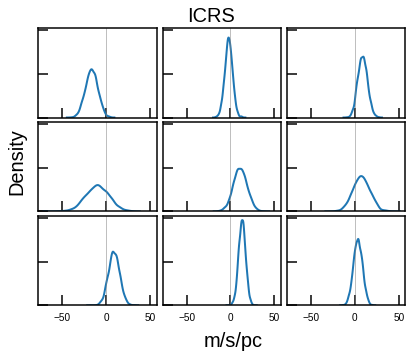

In [13]:
plot_T_icrs(stanfit['vanilla']);

omega = 9.889913054629172 +- 4.434443179281004


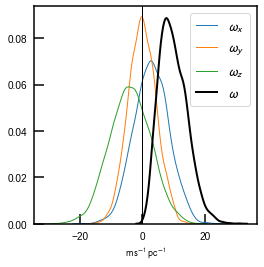

In [18]:
plot_omegas(stanfit['vanilla']);

omegax = 1.811967849669184 +- 3.8827189105467848
omegay = -1.5082454732516035 +- 7.38881384139993
omegaz = -4.244104616588751 +- 4.922817742395801
omega = 9.889913054629174 +- 4.434443179281005


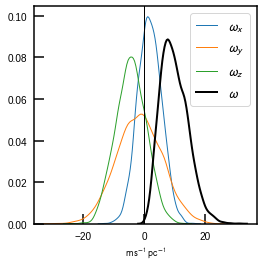

In [19]:
wT = decompose_T(rotate_T_to_galactic(stanfit['vanilla']["T_param"]))
fig, ax = plt.subplots(figsize=(4,4))
sns.distplot(wT["omegax"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
sns.distplot(wT["omegay"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
sns.distplot(wT["omegaz"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
omega = np.sqrt(wT["omegax"] ** 2 + wT["omegay"] ** 2 + wT["omegaz"] ** 2)
sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
ax.axvline(0, c='k', lw=1)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\rm m\,\rm s^{-1}\,\rm pc^{-1}$');

print(f"omegax = {np.mean(wT['omegax'])} +- {np.std(wT['omegax'])}")
print(f"omegay = {np.mean(wT['omegay'])} +- {np.std(wT['omegay'])}")
print(f"omegaz = {np.mean(wT['omegaz'])} +- {np.std(wT['omegaz'])}")
print(f"omega = {np.mean(omega)} +- {np.std(omega)}")

In [29]:
T_galactic = rotate_T_to_galactic(stanfit['vanilla']["T_param"])
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.
T_antisym = (T_galactic - np.transpose(T_galactic, (0, 2, 1))) / 2.

In [30]:
# math check
assert (
    (T_antisym[:, 2, 1] == decompose_T(T_galactic)["omegax"]).all(),
    (T_antisym[:, 0, 2] == decompose_T(T_galactic)["omegay"]).all(),
    (T_antisym[:, 1, 0] == decompose_T(T_galactic)["omegaz"]).all(),
) == (True, True, True)

In [31]:
# decompose and sort by eigenvalues
w, v = np.linalg.eig(T_sym)

i_wsort = np.argsort(w, axis=1)
# my numpy-fu running out...
sorted_v = np.stack([v[j][:,i] for j, i in enumerate(i_wsort)])
sorted_w = np.sort(w, axis=1)

# verify math
assert np.allclose(sorted_w.mean(axis=1), decompose_T(T_galactic)["kappa"]) == True

In [32]:
# sorted_v[:,:,0] *= np.sign(sorted_v[:,2,0])[:,None]
# sorted_v[:,:,1] *= np.sign(sorted_v[:,2,1])[:,None]
# sorted_v[:,:,2] *= np.sign(sorted_v[:,2,2])[:,None]

 -24.621 +-    7.908 (   3.113)-0.00550, -0.00809,  0.28380
   1.744 +-    4.134 (   0.422)-0.09140, -0.29234,  0.06330
  21.168 +-    7.147 (   2.962) 0.51448, -0.06333, -0.01004


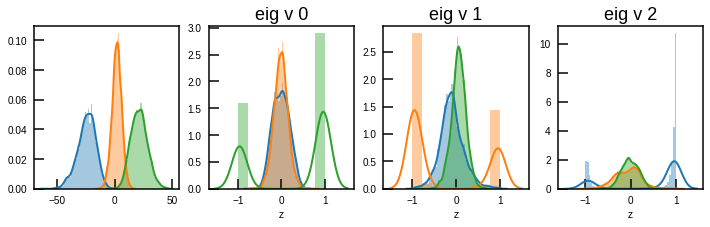

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
sns.distplot(sorted_w.T[0], ax=ax[0])
sns.distplot(sorted_w.T[1], ax=ax[0])
sns.distplot(sorted_w.T[2], ax=ax[0]);

for i in range(3):
    vd = pd.DataFrame(sorted_v[:,:,i], columns=['x','y','z'])
    for col in vd:
        sns.distplot(vd[col], ax=ax[i+1])#, legend=False)
    ax[i+1].set_title(f"eig v {i}")

for i, cw in enumerate(sorted_w.T):
    print(f"{np.mean(cw):8.3f} +- {np.std(cw):8.3f} ({np.abs(np.mean(cw)/np.std(cw)):8.3f})", end='')
    print(f"{np.mean(sorted_v[:,0,i]):-8.5f}, {np.mean(sorted_v[:,1,i]):-8.5f}, {np.mean(sorted_v[:,2,i]):-8.5f}")

In [35]:
%run smoh_utils.ipynb

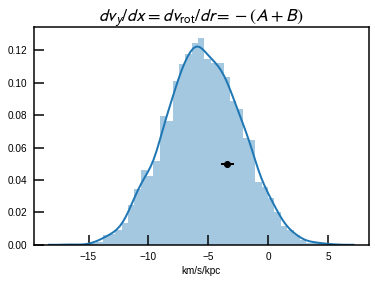

In [44]:
sns.distplot(T_galactic[:,1,0])
plt.errorbar([-bovy_oort['B']-bovy_oort['A']], [0.05],
             xerr=[np.hypot(bovy_oort['stdB'], bovy_oort['stdA'])],
             marker='o', color='k', ms=6)
plt.title(r'$d v_y / d x = d v_\mathrm{rot} / d r = -(A+B)$');
plt.xlabel("km/s/kpc");

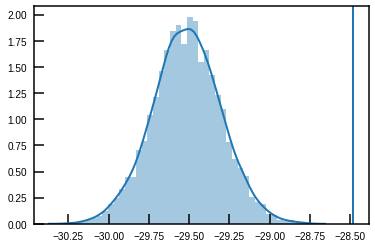

In [89]:
i=128
comp=2
sns.distplot(fit['a_model'][:,i,comp],)
plt.axvline(fit.data['a'][i,comp])

In [117]:
fit = stanfit['vanilla']

delta_a = fit.data['a'][None,:] - fit['a_model']
D = np.repeat(fit.data['C'].copy()[None], 4000, axis=0)
D[:,:,1, 1] += (fit['sigv']**2)[:,None] / (fit['d'] / 1e3)**2 / 4.74**2
D[:,:,2, 2] += (fit['sigv']**2)[:,None] / (fit['d'] / 1e3)**2 / 4.74**2
Dinv = np.linalg.inv(D)
g = np.einsum("sni,snij,snj->sn", delta_a, Dinv, delta_a)

In [158]:
chi2rv = (fit.data["rv"][None, :] - fit["rv_model"]) / (
    np.hypot(fit.data["rv_error"][None, :],  fit["sigv"][:, None])
)

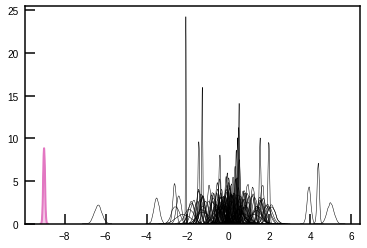

In [171]:
for i in range(fit.data['Nrv']):
    sns.distplot(chi2rv[:,i], hist=False, kde_kws={'lw':.5, 'color':'k'})
sns.distplot(chi2rv[:,62]);
# plt.plot(x, sp.stats.norm.pdf(x), 'k-');

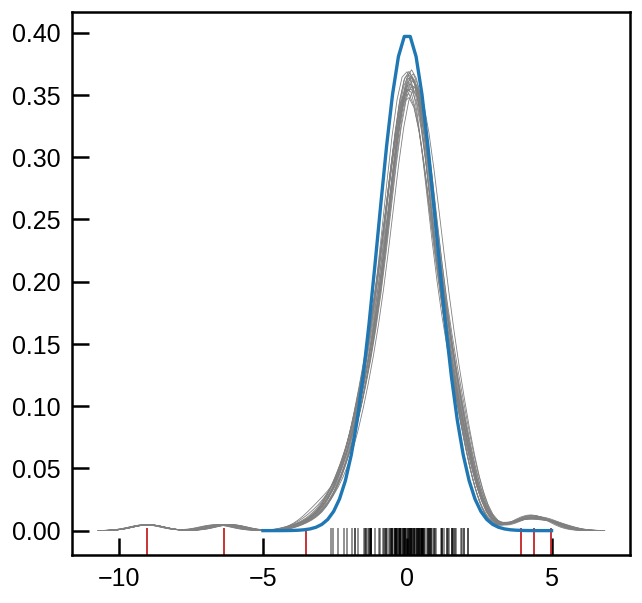

In [235]:
for i in range(20):
    sns.distplot(chi2rv[i,:], hist=False, kde_kws={'lw':.5, 'color':'gray'})
# sns.distplot(chi2rv[:,62]);
sns.rugplot(chi2rv.mean(axis=0), color='black', alpha=.5)

x=np.linspace(-5,5)
plt.plot(x, sp.stats.norm.pdf(x), '-');

# for iout in np.where(bool_rv_outliers)[0]:
#     sns.distplot(chi2rv[:,iout], hist=False, kde_kws={'lw':.5});
sns.rugplot(chi2rv.mean(axis=0)[bool_rv_outliers], color='tab:red')

In [207]:
reino_cutoff_norm = sp.stats.norm.ppf(1-0.0027)
reino_cutoff_chi23 = sp.stats.chi2(df=3).ppf(1-0.0027)
print(f"reino prob cutoff of 0.0027 for Gaussian: {reino_cutoff_norm} sigma")
print(f"reino prob cutoff of 0.0027 for chi2(3): {reino_cutoff_chi23} sigma")

reino prob cutoff of 0.0027 for Gaussian: 2.7821504537846025 sigma
reino prob cutoff of 0.0027 for chi2(3): 14.1562525005409 sigma


In [242]:
sp.stats.norm.cdf(-3)

0.0013498980316300933

In [243]:
sp.stats.chi2(df=3).ppf(1-0.00135)

15.63040328995176

In [221]:
# outliers by 3-sigma
bool_rv_outliers = np.abs(chi2rv.mean(axis=0))>3
print(bool_rv_outliers.sum())
idx_rv_outliers = fit.data['irv'][bool_rv_outliers]
print("index of outliers in original df :", idx_rv_outliers)

6
index of outliers in original df : [ 96 156 187 333 349 501]


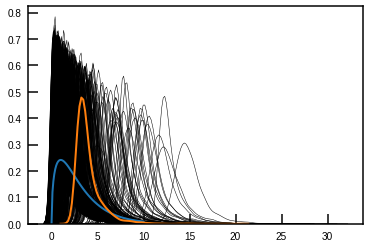

In [172]:
for i in range(500):
    sns.distplot(g[:,i], hist=False, kde_kws={'lw':.5, 'color':'k'});
x=np.linspace(0,10,101)
pdfx= sp.stats.chi2(df=3).pdf(x)
plt.plot(x, pdfx)
sns.distplot(g[:,187], hist=False, kde_kws={'lw':2});

0


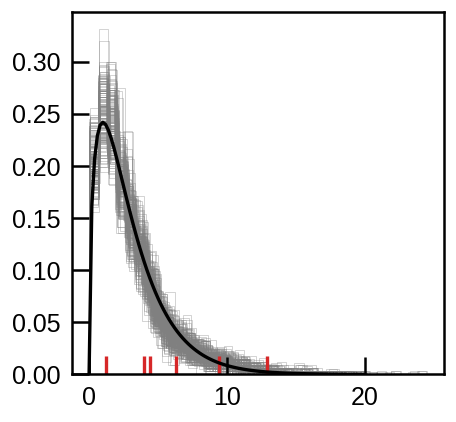

In [245]:
plt.figure(figsize=(4,4))
for i in range(200):
    #     sns.distplot(g[i,:], hist=False, kde_kws={'lw':.5, 'color':'k'});
    sns.distplot(
        g[i, :],
        hist=True,
        kde=False,
        hist_kws={"histtype": "step", "lw": 0.5, "color": "grey", "density": True},
    )
x = np.linspace(0, 20, 101)
pdfx = sp.stats.chi2(df=3).pdf(x)
plt.plot(x, pdfx, "k-", )

# check where RV outliers are
sns.rugplot(g.mean(axis=0)[idx_rv_outliers], color='tab:red', lw=2)

print(np.sum(g.mean(axis=0)>15.63))
# sns.distplot(g[:,187], hist=False, kde_kws={'lw':2});

Fit after dropping RV outliers.

In [247]:
df_rvcleaned_dr2 = (
    df_vanilla_dr2.copy().drop(index=idx_rv_outliers).reset_index(drop=True)
)

In [248]:
%%time
m = kn.Fitter() #recompile=True)
b0 = np.median(hy_dr2.g.icrs.cartesian.xyz.value, axis=1)
print(f"b0 = {b0}")

INFO:kinesis.models:Reading model from disk


b0 = [17.26821532 41.64304963 13.606407  ]
CPU times: user 5.51 ms, sys: 4.49 ms, total: 10 ms
Wall time: 12.5 ms


In [249]:
%%time
stanfit['rvcleaned'] = m.fit(df_rvcleaned_dr2, b0=b0, pars=None)
azfit['rvcleaned'] = az.from_pystan(stanfit['rvcleaned'])

CPU times: user 37.9 s, sys: 1.93 s, total: 39.8 s
Wall time: 5min 2s


In [448]:
az.summary(azfit['rvcleaned'], var_names=['v0', 'sigv', 'T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.078,0.023,0.000,0.000,-6.122,-6.035,2829.0,2829.0,2830.0,2857.0,1.0
v0[1],45.670,0.039,0.001,0.001,45.595,45.743,2624.0,2624.0,2625.0,2542.0,1.0
v0[2],5.538,0.021,0.000,0.000,5.502,5.579,2887.0,2887.0,2882.0,3039.0,1.0
sigv,0.377,0.009,0.000,0.000,0.361,0.394,4296.0,4291.0,4300.0,3060.0,1.0
"T_param[0,0]",-16.344,6.833,0.145,0.103,-28.965,-3.433,2220.0,2220.0,2225.0,2677.0,1.0
"T_param[0,1]",0.003,4.233,0.097,0.068,-8.144,7.673,1914.0,1914.0,1914.0,2590.0,1.0
"T_param[0,2]",9.468,5.401,0.118,0.083,-0.343,19.626,2110.0,2110.0,2111.0,2692.0,1.0
"T_param[1,0]",-12.342,12.816,0.292,0.206,-36.272,11.816,1928.0,1928.0,1928.0,2512.0,1.0
"T_param[1,1]",15.666,7.639,0.185,0.131,1.748,30.439,1704.0,1704.0,1702.0,2418.0,1.0
"T_param[1,2]",9.512,9.749,0.223,0.157,-9.678,26.575,1920.0,1920.0,1917.0,2587.0,1.0


In [259]:
%run smoh_utils.ipynb

In [271]:
aa=azfit['vanilla']

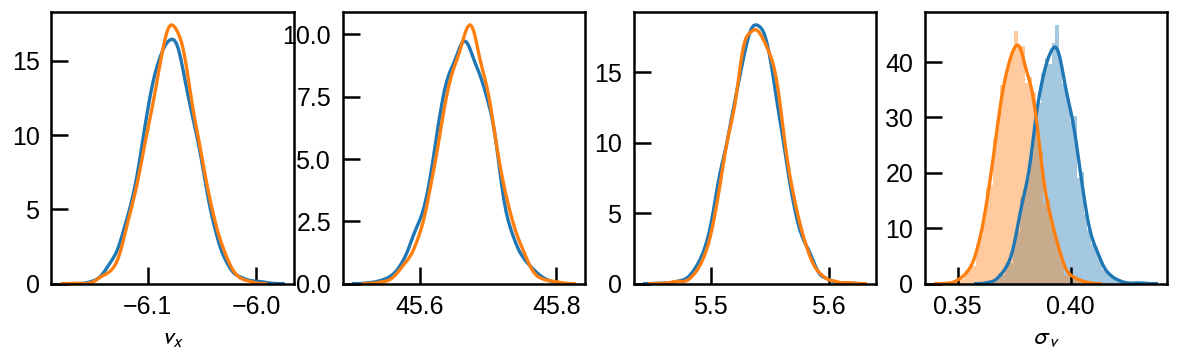

In [284]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))

for i in range(3):
    sns.distplot(stanfit['vanilla']['v0'][:,i], ax=ax[i], hist=False)
    sns.distplot(stanfit['rvcleaned']['v0'][:,i],ax=ax[i], hist=False);
ax[0].set_xlabel("$v_x$");

sns.distplot(stanfit['vanilla']['sigv'], ax=ax[3])
sns.distplot(stanfit['rvcleaned']['sigv'],ax=ax[3]);
ax[3].set_xlabel("$\sigma_v$");

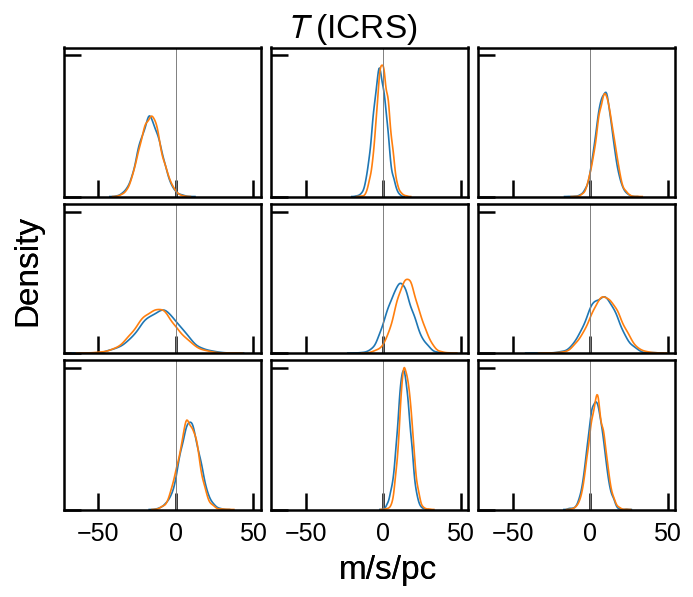

In [260]:
fig=plot_T_icrs(stanfit['vanilla'])
fig=plot_T_icrs(stanfit['rvcleaned'], fig=fig)

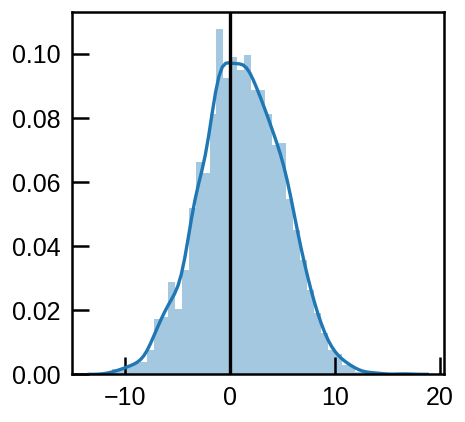

In [266]:
plt.figure(figsize=(4,4))
sns.distplot(
    decompose_T(rotate_T_to_galactic(stanfit["rvcleaned"]["T_param"]))["kappa"]
)
plt.axvline(0, c='k')

Would there be more outliers?

In [285]:
fit = stanfit['rvcleaned']

delta_a = fit.data['a'][None,:] - fit['a_model']
D = np.repeat(fit.data['C'].copy()[None], 4000, axis=0)
D[:,:,1, 1] += (fit['sigv']**2)[:,None] / (fit['d'] / 1e3)**2 / 4.74**2
D[:,:,2, 2] += (fit['sigv']**2)[:,None] / (fit['d'] / 1e3)**2 / 4.74**2
Dinv = np.linalg.inv(D)
g = np.einsum("sni,snij,snj->sn", delta_a, Dinv, delta_a)

In [286]:
chi2rv = (fit.data["rv"][None, :] - fit["rv_model"]) / (
    np.hypot(fit.data["rv_error"][None, :],  fit["sigv"][:, None])
)

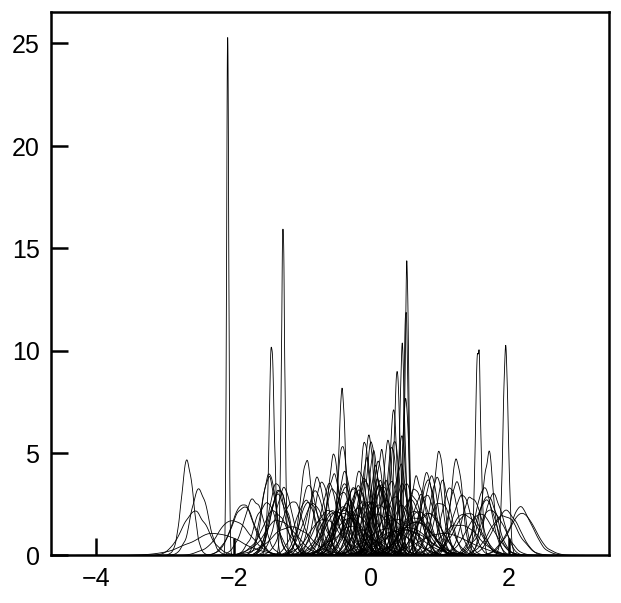

In [287]:
for i in range(fit.data['Nrv']):
    sns.distplot(chi2rv[:,i], hist=False, kde_kws={'lw':.5, 'color':'k'})
# plt.plot(x, sp.stats.norm.pdf(x), 'k-');

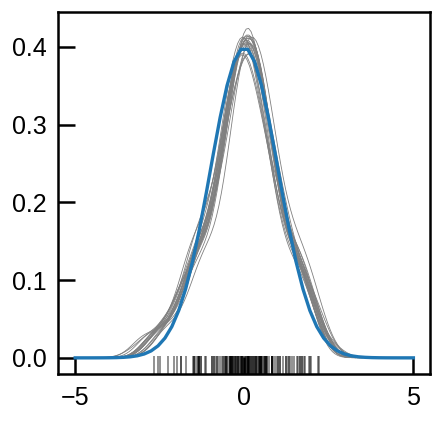

In [289]:
plt.figure(figsize=(4,4))
for i in range(20):
    sns.distplot(chi2rv[i,:], hist=False, kde_kws={'lw':.5, 'color':'gray'})
# sns.distplot(chi2rv[:,62]);
sns.rugplot(chi2rv.mean(axis=0), color='black', alpha=.5)

x=np.linspace(-5,5)
plt.plot(x, sp.stats.norm.pdf(x), '-');

In [435]:
T_galactic = rotate_T_to_galactic(stanfit['rvcleaned']["T_param"])
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.
T_antisym = (T_galactic - np.transpose(T_galactic, (0, 2, 1))) / 2.

In [436]:
# math check
assert (
    (T_antisym[:, 2, 1] == decompose_T(T_galactic)["omegax"]).all(),
    (T_antisym[:, 0, 2] == decompose_T(T_galactic)["omegay"]).all(),
    (T_antisym[:, 1, 0] == decompose_T(T_galactic)["omegaz"]).all(),
) == (True, True, True)

In [437]:
# decompose and sort by eigenvalues
w, v = np.linalg.eig(T_sym)

i_wsort = np.argsort(w, axis=1)
# my numpy-fu running out...
sorted_v = np.stack([v[j][:,i] for j, i in enumerate(i_wsort)])
sorted_w = np.sort(w, axis=1)

# verify math
assert np.allclose(sorted_w.mean(axis=1), decompose_T(T_galactic)["kappa"]) == True

In [32]:
# sorted_v[:,:,0] *= np.sign(sorted_v[:,2,0])[:,None]
# sorted_v[:,:,1] *= np.sign(sorted_v[:,2,1])[:,None]
# sorted_v[:,:,2] *= np.sign(sorted_v[:,2,2])[:,None]

 -24.200 +-    7.675 (   3.153)-0.01726, -0.01420,  0.24257
   2.183 +-    4.015 (   0.544)-0.05982, -0.27873,  0.05709
  25.547 +-    7.141 (   3.578) 0.60717, -0.02009, -0.01275


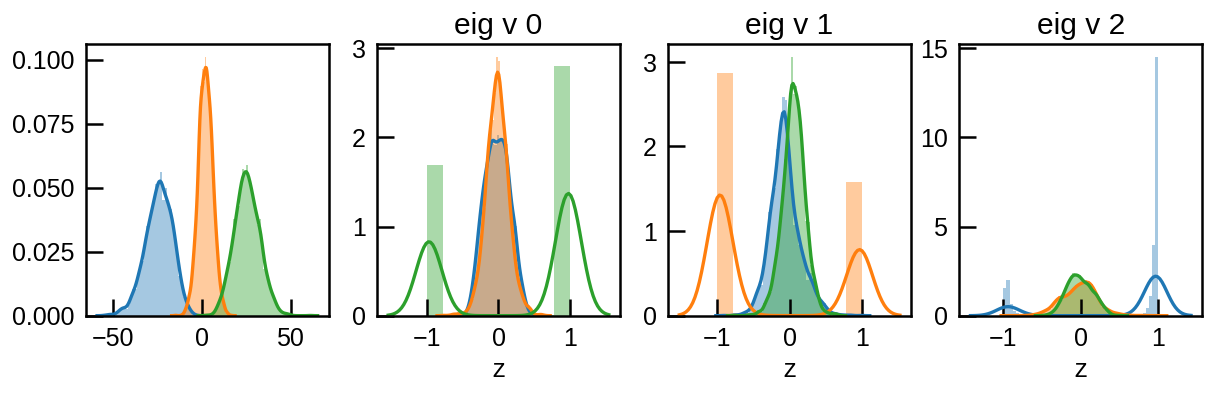

In [438]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
sns.distplot(sorted_w.T[0], ax=ax[0])
sns.distplot(sorted_w.T[1], ax=ax[0])
sns.distplot(sorted_w.T[2], ax=ax[0]);

for i in range(3):
    vd = pd.DataFrame(sorted_v[:,:,i], columns=['x','y','z'])
    for col in vd:
        sns.distplot(vd[col], ax=ax[i+1])#, legend=False)
    ax[i+1].set_title(f"eig v {i}")

for i, cw in enumerate(sorted_w.T):
    print(f"{np.mean(cw):8.3f} +- {np.std(cw):8.3f} ({np.abs(np.mean(cw)/np.std(cw)):8.3f})", end='')
    print(f"{np.mean(sorted_v[:,0,i]):-8.5f}, {np.mean(sorted_v[:,1,i]):-8.5f}, {np.mean(sorted_v[:,2,i]):-8.5f}")

In [ ]:
df_rvcleaned_dr2.g.vra_erro

## Null test

We make a cluster with $T=0$.

In [497]:
v0 = [-6.07, 45.66, 5.53]
b0 = [17.27, 41.64, 13.60]
sigmav = 0.38
print(f"b0=f{b0}")
clT0 = (
    kn.Cluster(v0=v0, sigmav=sigmav, b0=b0)
    .sample_at(df_rvcleaned_dr2.g.icrs)
    .observe(cov=df_rvcleaned_dr2.g.make_cov())
)

b0=f[17.27, 41.64, 13.6]


In [498]:
df_mock_T0 = clT0.members.observed.copy()
df_mock_T0["radial_velocity_error"] = df_rvcleaned_dr2["radial_velocity_error"]
df_mock_T0["radial_velocity"] = np.random.normal(
    clT0.members.truth["radial_velocity"].values,
    scale=df_mock_T0["radial_velocity_error"].values,
)

In [513]:
%%time
m = kn.Fitter()
stanfit['mockT0_4'] = m.fit(df_mock_T0, b0=b0, pars=None)
azfit['mockT0_4'] = az.from_pystan(stanfit['mockT0_4'])

INFO:kinesis.models:Reading model from disk


CPU times: user 43.5 s, sys: 5.89 s, total: 49.4 s
Wall time: 8min 17s


In [467]:
az.summary(azfit['mockT0'], var_names=['v0', 'sigv', 'T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.072,0.024,0.000,0.000,-6.117,-6.026,2372.0,2372.0,2373.0,2943.0,1.0
v0[1],45.755,0.042,0.001,0.001,45.676,45.833,2146.0,2146.0,2150.0,2436.0,1.0
v0[2],5.559,0.022,0.000,0.000,5.518,5.600,2356.0,2356.0,2356.0,2356.0,1.0
sigv,0.391,0.009,0.000,0.000,0.375,0.408,3685.0,3685.0,3689.0,3088.0,1.0
"T_param[0,0]",-0.507,7.031,0.147,0.104,-14.260,12.259,2287.0,2287.0,2286.0,2966.0,1.0
"T_param[0,1]",4.536,4.495,0.097,0.069,-3.621,13.086,2146.0,2146.0,2146.0,2877.0,1.0
"T_param[0,2]",-0.728,5.545,0.121,0.086,-10.654,10.108,2087.0,2087.0,2087.0,2654.0,1.0
"T_param[1,0]",-0.173,13.023,0.299,0.212,-24.023,23.850,1893.0,1893.0,1891.0,2513.0,1.0
"T_param[1,1]",7.923,7.704,0.167,0.118,-6.893,22.284,2129.0,2129.0,2128.0,2655.0,1.0
"T_param[1,2]",-11.455,10.118,0.226,0.160,-30.487,7.332,2009.0,2009.0,2009.0,2856.0,1.0


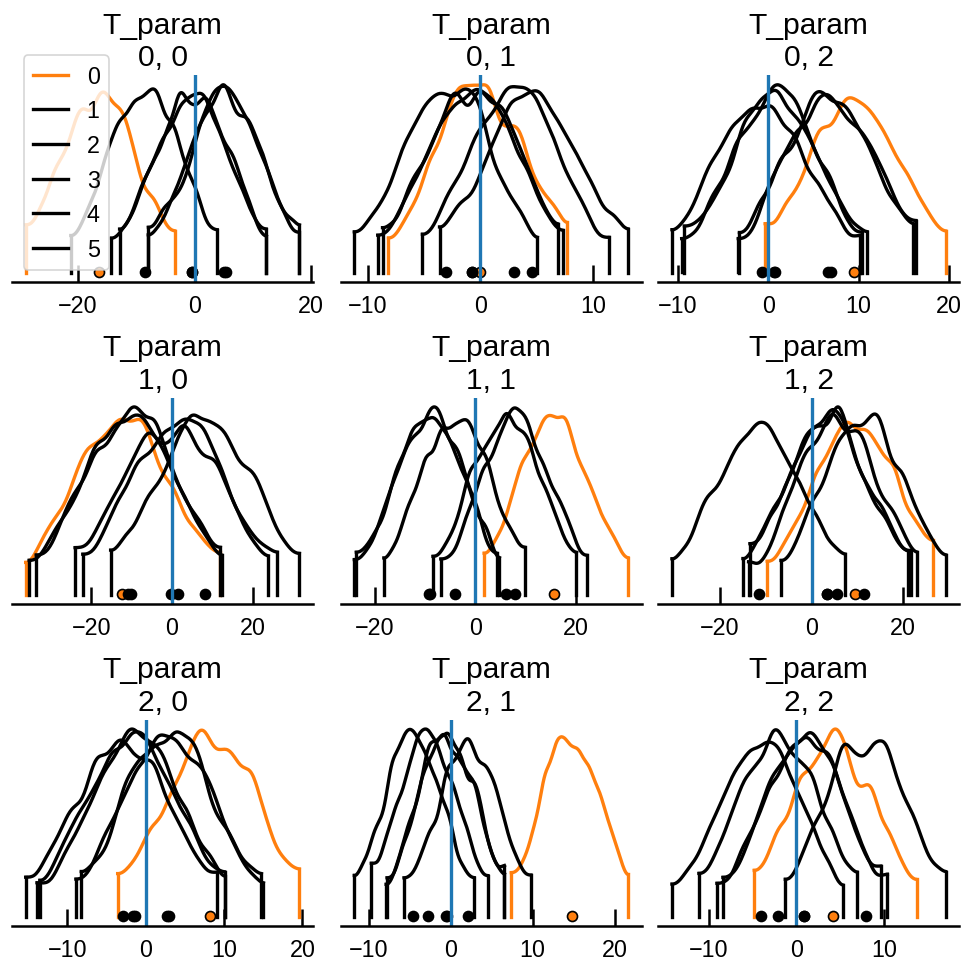

In [516]:
ax = az.plot_density(
    [
        azfit["rvcleaned"],
        azfit["mockT0"],
        azfit["mockT0_1"],
        azfit["mockT0_2"],
        azfit["mockT0_3"],
        azfit["mockT0_4"],
    ],
    var_names="T_param",
    colors=["tab:orange", "k", "k", "k", "k", "k"],
    figsize=(8, 8),
)
for cax in ax:
    cax.axvline(0)

In [507]:
%run smoh_utils.ipynb

In [531]:
v = rotate_T_to_galactic(stanfit['rvcleaned']['T_param'])[:,2,2]
print(f"{'rvcleaned':8s}", f"{np.mean(v):-8.3f} {np.std(v):-8.3f} {np.abs(np.mean(v))/np.std(v):-8.3f}")
for label, fit in stanfit.items():
    if 'mock' in label:
        v = rotate_T_to_galactic(fit['T_param'])[:,2,2]
        print(f"{label:8s}", f"{np.mean(v):-8.3f} {np.std(v):-8.3f} {np.abs(np.mean(v))/np.std(v):-8.3f}")

rvcleaned  -22.133    7.058    3.136
mockT0      2.120    7.440    0.285
mockT0_1   -9.228    7.101    1.300
mockT0_2    0.501    7.000    0.072
mockT0_3    0.276    7.240    0.038
mockT0_4    0.083    7.072    0.012


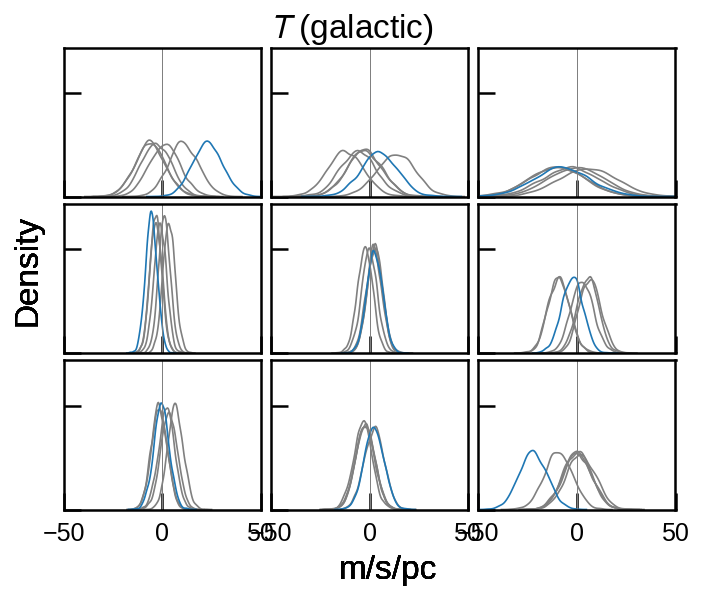

In [517]:
fig = plot_T_galactic(stanfit['mockT0'], color='gray')
fig = plot_T_galactic(stanfit['mockT0_1'], fig=fig, color='gray')
fig = plot_T_galactic(stanfit['mockT0_2'], fig=fig,color='gray')
fig = plot_T_galactic(stanfit['mockT0_3'], fig=fig,color='gray')
fig = plot_T_galactic(stanfit['mockT0_4'], fig=fig,color='gray')
fig = plot_T_galactic(stanfit['rvcleaned'], fig=fig)
for cax in fig.axes:cax.set_xlim(-50,50)

In [6]:
stanfit = {}
azfit = {}

## What signal?

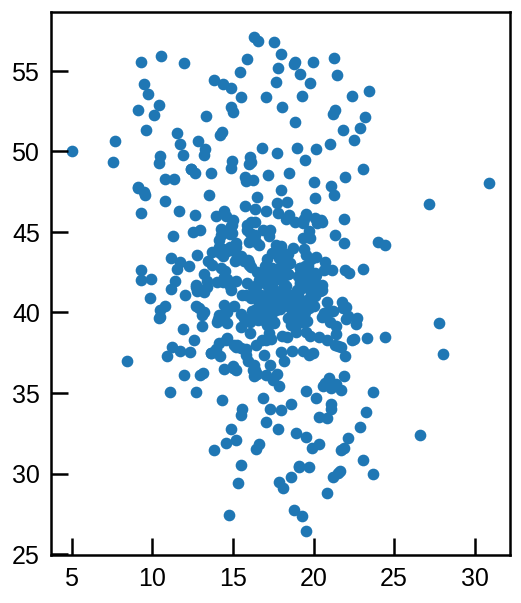

In [688]:
coi = df_rvcleaned_dr2.g.icrs
cog = df_rvcleaned_dr2.g.galactic.cartesian
plt.axes(aspect='equal')
plt.scatter(coi.x, coi.y);


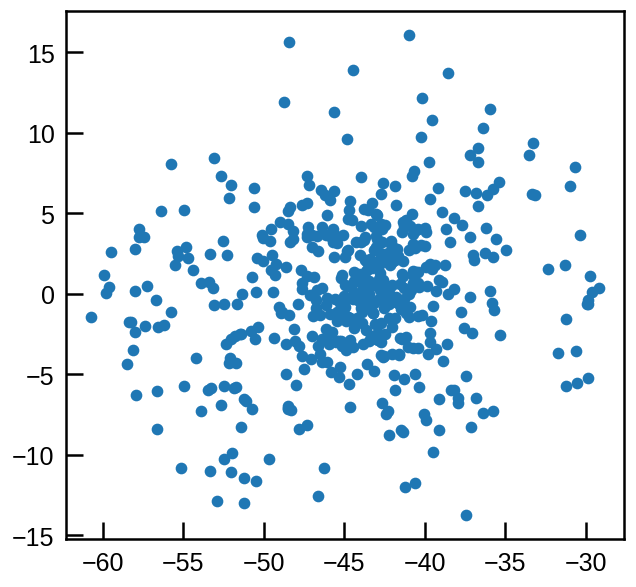

In [689]:
coi = df_rvcleaned_dr2.g.icrs.cartesian
cog = df_rvcleaned_dr2.g.galactic.cartesian
plt.axes(aspect='equal')
plt.scatter(cog.x, cog.y);


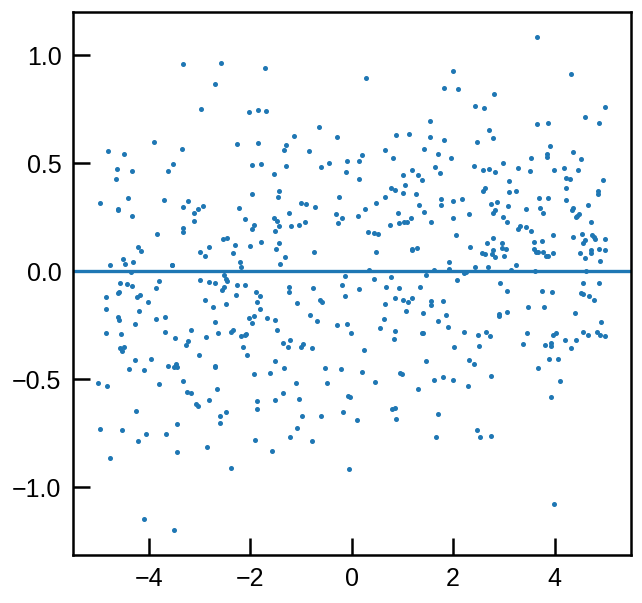

In [546]:
x = np.random.uniform(-5, 5, 500)
y = np.random.normal(scale=0.38, size=500) + x*20*1e-3
plt.scatter(x, y, s=4);
plt.axhline(0);

In [559]:
b0_coord = coord.ICRS(x=b0[0]*u.pc, y=b0[1]*u.pc, z=b0[2]*u.pc,
                      representation_type='cartesian')
b0_gal = b0_coord.transform_to(coord.Galactic).cartesian.xyz

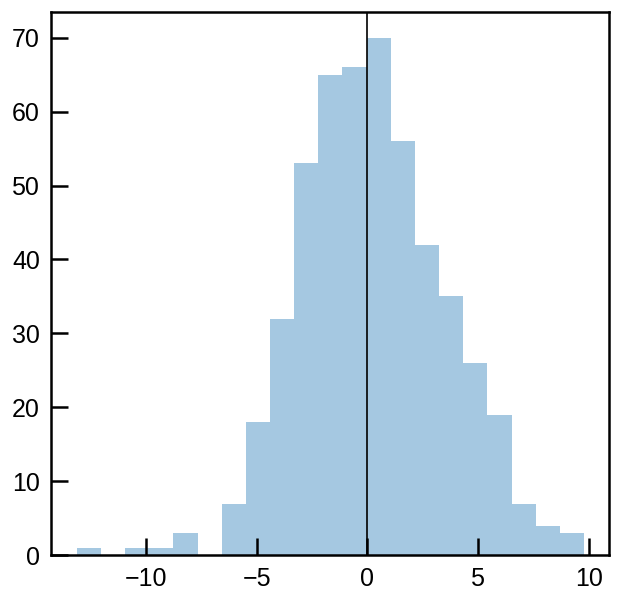

In [564]:
sns.distplot(df_rvcleaned_dr2.g.galactic.cartesian.z-b0_gal[2], kde=False);
plt.axvline(0,c='k', lw=1);

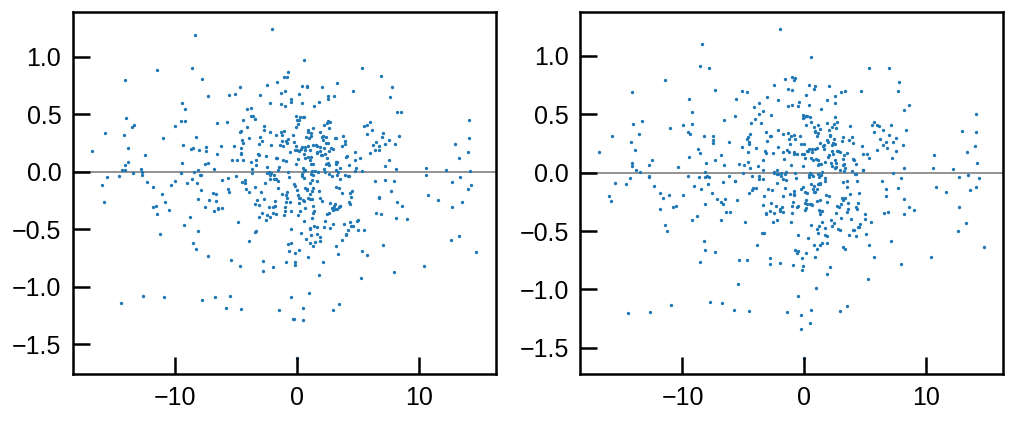

In [597]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.x - b0_gal[0],
    df_rvcleaned_dr2.g.vra - cl.members.truth.g.vra,
    s=1,
)
ax[1].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.x - b0_gal[0],
    df_rvcleaned_dr2.g.vra - clT.members.truth.g.vra,
    s=1,
)
for cax in ax: cax.axhline(0, lw=1, c='gray', zorder=-10);

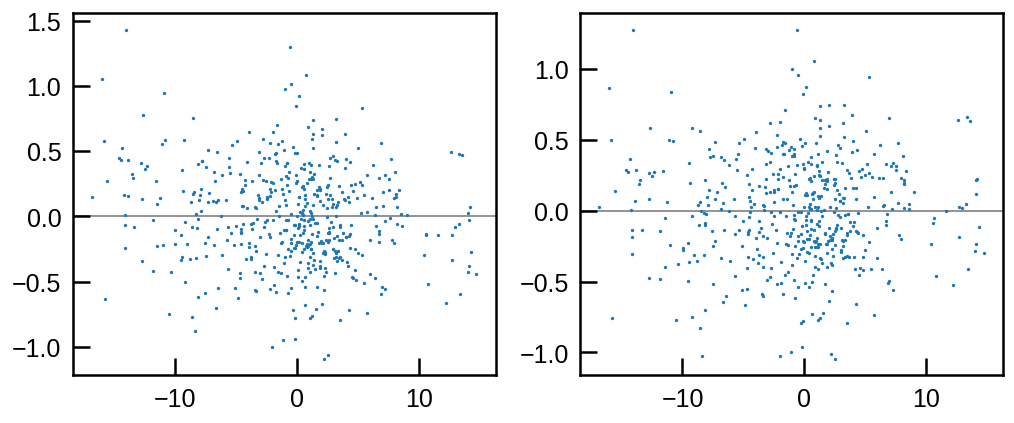

In [599]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.x - b0_gal[0],
    df_rvcleaned_dr2.g.vdec - cl.members.truth.g.vdec,
    s=1,
)
ax[1].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.x - b0_gal[0],
    df_rvcleaned_dr2.g.vdec - clT.members.truth.g.vdec,
    s=1,
)
for cax in ax: cax.axhline(0, lw=1, c='gray', zorder=-10);

In [601]:
coord.ICRS(x=3, y=4, z=0, representation_type="cartesian").transform_to(
    coord.Galactic
).cartesian.xyz

<Quantity [-3.65837518, -0.29699057, -3.39530376]>

In [607]:
cc = coord.ICRS(
    x=0 * u.pc,
    y=0 * u.pc,
    z=0 * u.pc,
    v_x=1 * u.km / u.s,
    v_y=0 * u.km / u.s,
    v_z=0 * u.km / u.s,
    representation_type="cartesian",
    differential_type="cartesian",
).transform_to(coord.Galactic)

In [608]:
cc.cartesian, cc.velocity

(<CartesianRepresentation (x, y, z) in pc
     (0., 0., 0.)
  (has differentials w.r.t.: 's')>,
 <CartesianDifferential (d_x, d_y, d_z) in km / s
     (-0.05487566, 0.49410944, -0.86766614)>)

In [715]:
tmp = df_rvcleaned_dr2.copy()
tmp['radial_velocity'] = cl.members.truth['radial_velocity']
# tmp['radial_velocity'] = 0.

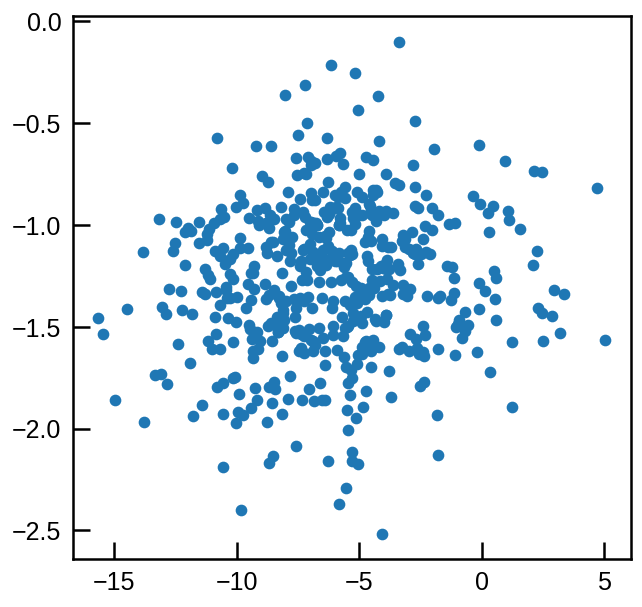

In [716]:
# plt.axes(aspect='equal')
plt.scatter(tmp.g.vdec, tmp.g.galactic.velocity.d_z)

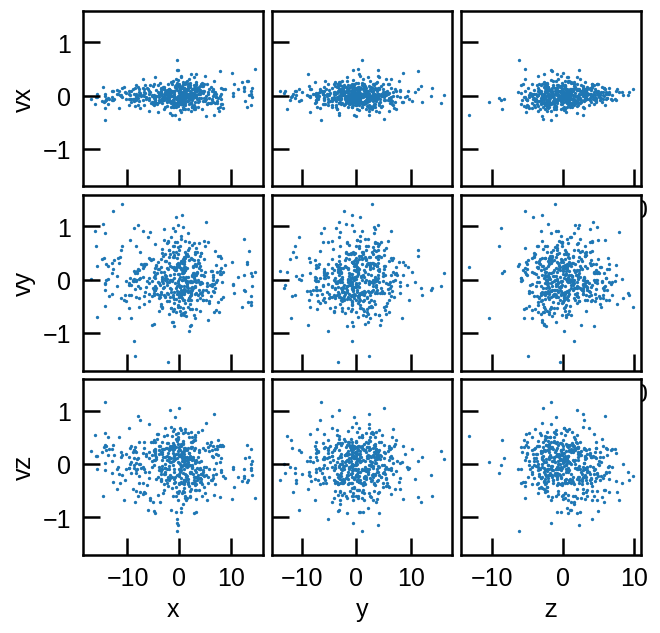

In [717]:
fig, ax = plt.subplots(3, 3, figsize=(6,6), sharex=False, sharey=True)
fig.subplots_adjust(wspace=.05, hspace=.05)

pos = tmp.g.galactic.cartesian.xyz
vel = tmp.g.galactic.velocity.d_xyz
relpos = pos - np.median(pos, axis=1)[:,None]
relvel = vel - np.median(vel, axis=1)[:,None]

ax[0,0].scatter(relpos[0], relvel[0], s=1)
ax[1,0].scatter(relpos[0], relvel[1], s=1)
ax[2,0].scatter(relpos[0], relvel[2], s=1)

ax[0,1].scatter(relpos[1], relvel[0], s=1)
ax[1,1].scatter(relpos[1], relvel[1], s=1)
ax[2,1].scatter(relpos[1], relvel[2], s=1)

ax[0,2].scatter(relpos[2], relvel[0], s=1)
ax[1,2].scatter(relpos[2], relvel[1], s=1)
ax[2,2].scatter(relpos[2], relvel[2], s=1)

# mrT = rotate_T_to_galactic(stanfit['rvcleaned']['T_param']).mean(axis=0)
# x=np.linspace(-10,10)
# for i in range(3):
#     for j in range(3):
#         ax[i,j].plot(x, mrT[i,j]/1e3*x, c='k', lw=1)

for i, l in enumerate(['x','y','z']): ax[2,i].set_xlabel(l)
for i, l in enumerate(['vx','vy','vz']): ax[i, 0].set_ylabel(l)

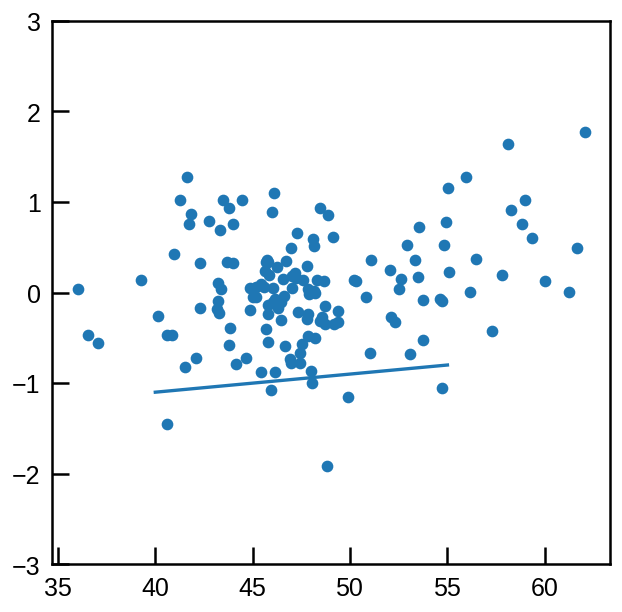

In [702]:
# plt.axes(aspect="equal")
plt.scatter(
    1e3 / df_rvcleaned_dr2["parallax"],
    df_rvcleaned_dr2["radial_velocity"] - cl.members.truth["radial_velocity"],
)
plt.ylim(-3,3)
x=np.linspace(40,55)
plt.plot(x, 20e-3*(x-45)-1)

In [678]:
sp.stats.pearsonr(
    tmp.g.galactic.cartesian.z-np.median(tmp.g.galactic.cartesian.z),
    tmp.g.galactic.velocity.d_z)

(-0.14147312541038207, 0.00137408030681297)

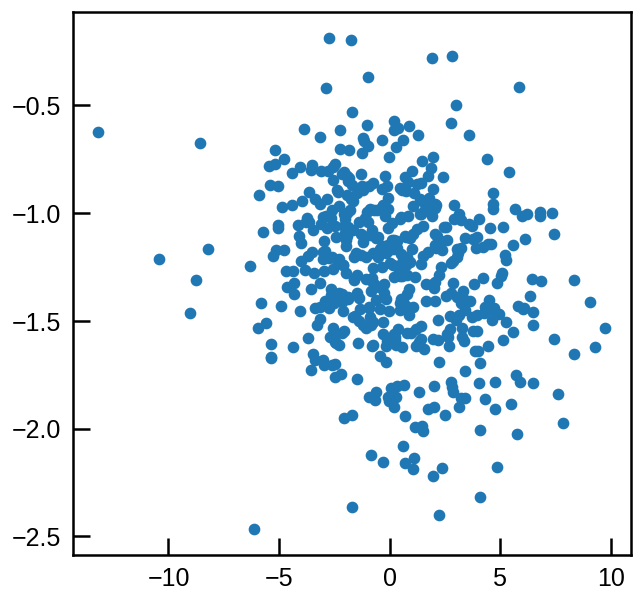

In [683]:
plt.scatter(
    tmp.g.galactic.cartesian.z-np.median(tmp.g.galactic.cartesian.z),
    tmp.g.galactic.velocity.d_z)

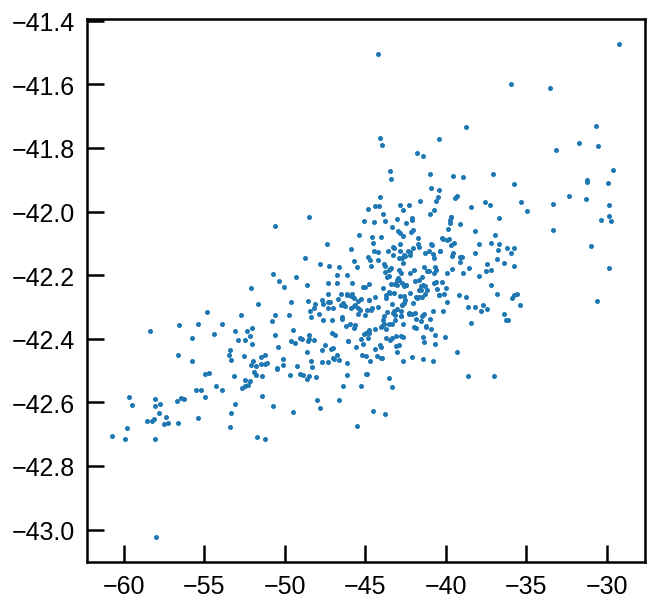

In [684]:
plt.scatter(
    tmp.g.galactic.cartesian.x,
    tmp.g.galactic.velocity.d_x, s=4)
# plt.scatter(
#     df_rvcleaned_dr2.g.galactic.cartesian.x,
#     df_rvcleaned_dr2.g.galactic.velocity.d_x, s=4)
# plt.ylim(-45,-40)
# x=np.linspace(-55,-35)
# plt.plot(x, 20e-3*(x+45)-43)

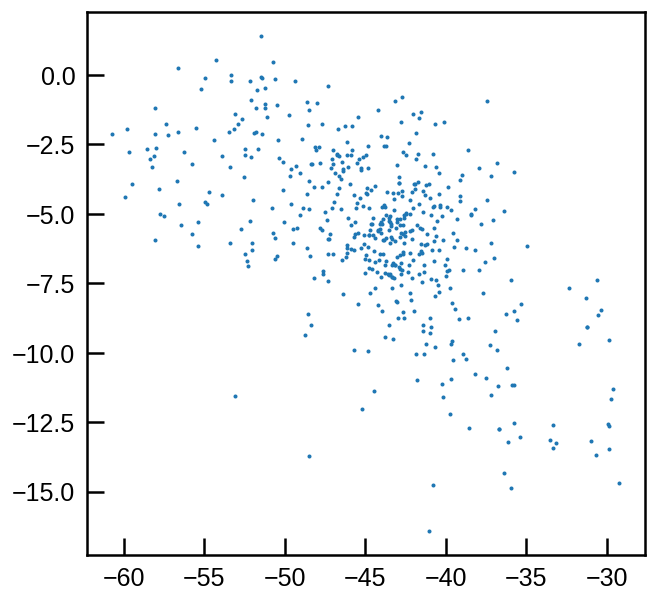

In [627]:
plt.scatter(
    tmp.g.galactic.cartesian.x,
    tmp.g.galactic.velocity.d_x, s=2)

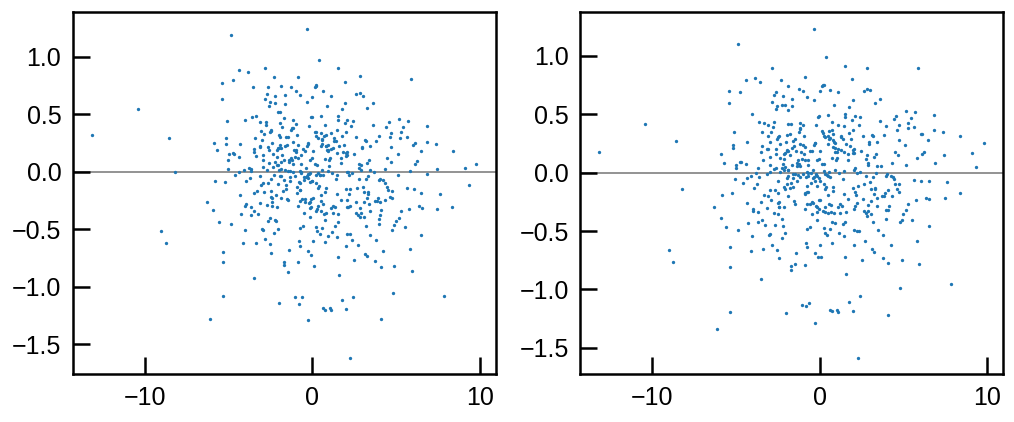

In [594]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(
    tmp.g.galactic.cartesian.z,
    tmp.g.vra - cl.members.truth.g.vra,
    s=1,
)
ax[1].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.z - b0_gal[2],
    df_rvcleaned_dr2.g.vra - clT.members.truth.g.vra,
    s=1,
)
for cax in ax: cax.axhline(0, lw=1, c='gray', zorder=-10);

In [ ]:
df_rvcleaned_dr2.g.

In [600]:
rotmat

array([[-0.05487566, -0.87343705, -0.48383507],
       [ 0.49410944, -0.44482972,  0.74698218],
       [-0.86766614, -0.19807634,  0.45598381]])

In [602]:
np.einsum('ij,j->i', rotmat, [3,4,0])

array([-3.65837518, -0.29699057, -3.39530376])

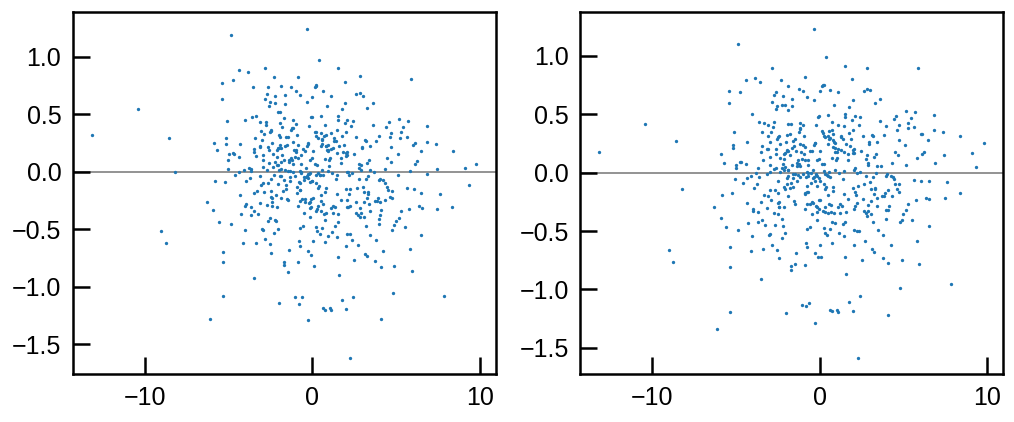

In [594]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.z - b0_gal[2],
    df_rvcleaned_dr2.g.vra - cl.members.truth.g.vra,
    s=1,
)
ax[1].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.z - b0_gal[2],
    df_rvcleaned_dr2.g.vra - clT.members.truth.g.vra,
    s=1,
)
for cax in ax: cax.axhline(0, lw=1, c='gray', zorder=-10);

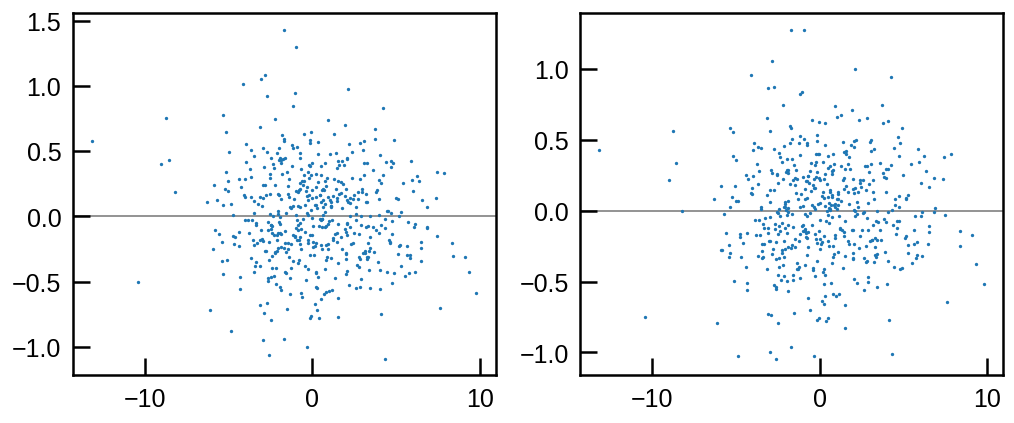

In [595]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.z - b0_gal[2],
    df_rvcleaned_dr2.g.vdec - cl.members.truth.g.vdec,
    s=1,
)
ax[1].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.z - b0_gal[2],
    df_rvcleaned_dr2.g.vdec - clT.members.truth.g.vdec,
    s=1,
)
for cax in ax: cax.axhline(0, lw=1, c='gray', zorder=-10);

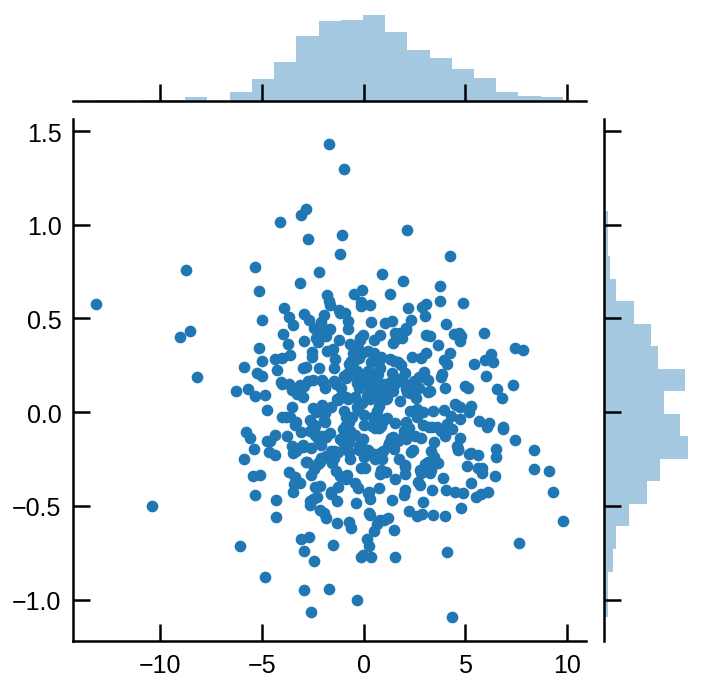

In [572]:
sns.jointplot(df_rvcleaned_dr2.g.galactic.cartesian.z-b0_gal[2],
              df_rvcleaned_dr2.g.vdec-cl.members.truth.g.vdec);

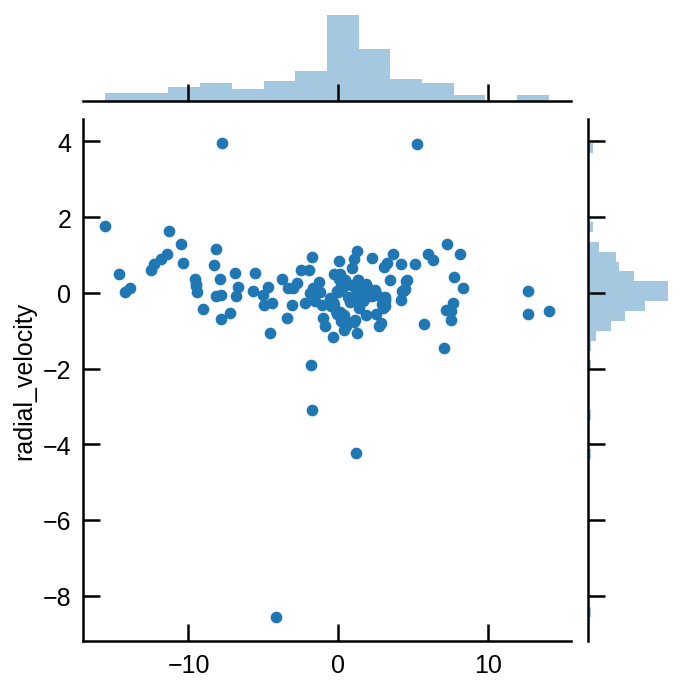

In [575]:
sns.jointplot(df_rvcleaned_dr2.g.galactic.cartesian.x-b0_gal[0],
              df_rvcleaned_dr2['radial_velocity']-cl.members.truth['radial_velocity']);

In [532]:
rotmat = coord.ICRS(
    [1, 0, 0], [0, 1, 0], [0, 0, 1], representation_type=coord.CartesianRepresentation
).transform_to(coord.Galactic).cartesian.xyz.value

In [533]:
rotmat

array([[-0.05487566, -0.87343705, -0.48383507],
       [ 0.49410944, -0.44482972,  0.74698218],
       [-0.86766614, -0.19807634,  0.45598381]])

In [56]:
%%time
stanfit['vanilla'] = m.fit(df_vanilla_dr2, b0=b0, pars=None)
azfit['vanilla'] = az.from_pystan(stanfit['vanilla'])

CPU times: user 36.5 s, sys: 1.91 s, total: 38.5 s
Wall time: 7min 43s


In [319]:
fit = stanfit['rvcleaned']

In [372]:
for k,v in decompose_T(fit['T_param']).items():
    print(k, np.mean(v), np.std(v),  np.abs(np.mean(v))/np.std(v))

omegax 2.6237862472763265 5.51679348614289 0.47559986681878996
omegay 0.6145886832943327 4.377935139446534 0.1403832317561539
omegaz -6.172702608925529 6.322453060826883 0.9763145015928724
w1 12.13585292513772 4.944680124763286 2.4543251775500226
w2 8.853413777973328 3.884344294848548 2.2792556750736037
w3 -6.169787790045084 7.148765148448587 0.8630564386891407
w4 -16.343539789038772 6.833365684690961 2.3917262068461813
w5 15.665541192630881 7.638539533715953 2.0508555494783174
kappa 1.1764567995636963 3.8737916552065017 0.3036964566699141


In [368]:
np.abs(fit['T_param'].mean(axis=0))/fit['T_param'].std(axis=0)

array([[2.39172621e+00, 6.88657667e-04, 1.75285563e+00],
       [9.63077657e-01, 2.05085555e+00, 9.75712391e-01],
       [1.31367170e+00, 3.84571580e+00, 8.40706374e-01]])

In [320]:
wT = decompose_T(fit['T_param'].mean(axis=0))

In [321]:
[wT["omegax"], wT["omegay"], wT["omegaz"]]

[array([2.62378625]), array([0.61458868]), array([-6.17270261])]

In [566]:
v0 = fit["v0"].mean(axis=0)
sigmav = fit["sigv"].mean()
print(f"b0=f{b0}")
cl = kn.Cluster(v0=v0, sigmav=0, b0=b0).sample_at(df_rvcleaned_dr2.g.icrs)
clT = kn.Cluster(
    v0=v0,
    sigmav=0,
    b0=b0,
    omegas=[wT["omegax"][0], wT["omegay"][0], wT["omegaz"][0]],
    ws=[wT["w1"][0], wT["w2"][0], wT["w3"][0], wT["w4"][0], wT["w5"][0]],
    k=wT["kappa"][0],
).sample_at(df_rvcleaned_dr2.g.icrs)

b0=f[17.27, 41.64, 13.6]


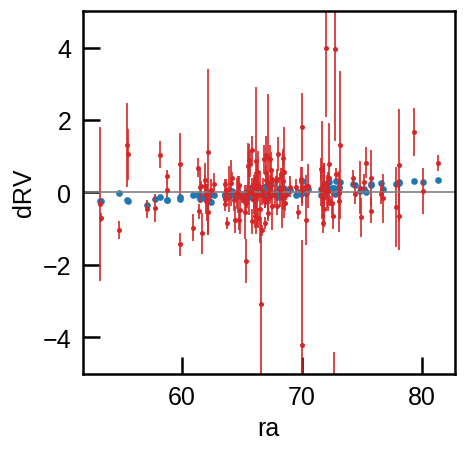

In [447]:
plt.figure(figsize=(4, 4))
# plt.scatter(
#     cl.members.truth.ra,
#     clT.members.truth["radial_velocity"] - cl.members.truth["radial_velocity"],
#     s=9,
# )
plt.xlabel("ra")
plt.ylabel("dRV")

irv = fit.data["irv"]
plt.scatter(
    cl.members.truth.ra[irv],
    (clT.members.truth["radial_velocity"] - cl.members.truth["radial_velocity"])[irv],
    s=9,
)

plt.errorbar(
    fit.data["ra"][irv], fit.data["rv"] - cl.members.truth["radial_velocity"][irv],
    yerr=fit.data["rv_error"], marker='o', elinewidth=1, ls='None', ms=2,
    color='tab:red'
)
plt.ylim(-5,5);
plt.axhline(0, c='gray', lw=1)

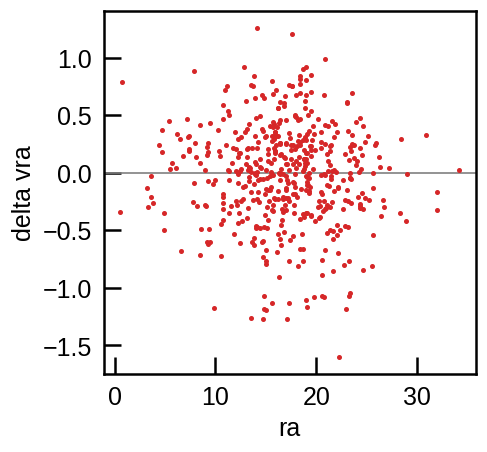

In [417]:
plt.figure(figsize=(4, 4))
plt.xlabel("ra")
plt.ylabel("delta vra")

# plt.scatter(
#     cl.members.truth.dec,
#     (clT.members.truth.g.vra - cl.members.truth.g.vra),
#     s=9,
# )

# plt.scatter(
#     hy_tails_r19_full["dec"], hy_tails_r19_full.g.vra - cl.members.truth.g.vra, s=1
# )

plt.errorbar(
    fit.data["dec"],
    df_rvcleaned_dr2.g.vra - cl.members.truth.g.vra,
    #     yerr=fit.data["rv_error"],
    marker="o",
    elinewidth=1,
    ls="None",
    ms=2,
    color="tab:red",
)
# plt.ylim(-5,5);
plt.axhline(0, c="gray", lw=1)

In [387]:
sp.stats.pearsonr(df_rvcleaned_dr2.g.icrs.cartesian.y,
    df_rvcleaned_dr2.g.vdec - cl.members.truth.g.vdec,)

(0.12816599966398015, 0.0037746905736643203)

In [413]:
np.mean(
    
    (clT.members.truth.g.vra - cl.members.truth.g.vra)/
cl.members.truth.g.icrs.cartesian.z.value)

-0.00042116693257929645

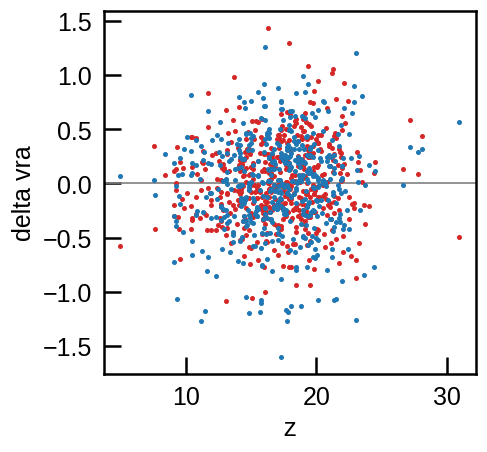

In [424]:
plt.figure(figsize=(4, 4))
plt.xlabel("z")
plt.ylabel("delta vra")


# plt.scatter(
#     cl.members.truth.g.icrs.cartesian.z,
#     (clT.members.truth.g.vra - cl.members.truth.g.vra),
#     s=9,
# )

plt.errorbar(
    df_rvcleaned_dr2.g.icrs.cartesian.x,
    df_rvcleaned_dr2.g.vdec - cl.members.truth.g.vdec,
    #     yerr=fit.data["rv_error"],
    marker="o",
    elinewidth=1,
    ls="None",
    ms=2,
    color="tab:red",
)
plt.errorbar(
    df_rvcleaned_dr2.g.icrs.cartesian.x,
    df_rvcleaned_dr2.g.vra - cl.members.truth.g.vra,
    #     yerr=fit.data["rv_error"],
    marker="o",
    elinewidth=1,
    ls="None",
    ms=2,
)

# plt.ylim(-5,5);
plt.axhline(0, c="gray", lw=1)
# x = np.linspace(1, 10)
# plt.plot(x, -0.4*x+1)

In [82]:
df_vanilla_dr2 = df_vanilla_dr2.assign(
    icrs_x=df_vanilla_dr2.g.icrs.cartesian.x,
    icrs_y=df_vanilla_dr2.g.icrs.cartesian.y,
    icrs_z=df_vanilla_dr2.g.icrs.cartesian.z,
    gal_x=df_vanilla_dr2.g.galactic.cartesian.x,
    gal_y=df_vanilla_dr2.g.galactic.cartesian.y,
    gal_z=df_vanilla_dr2.g.galactic.cartesian.z,
)

In [97]:
x, y, z = df_vanilla_dr2.g.icrs.cartesian.xyz
dx, dy, dz = x-x.mean(), y-y.mean(), z-z.mean()
dr = np.sqrt(dx**2+dy**2+dz**2)

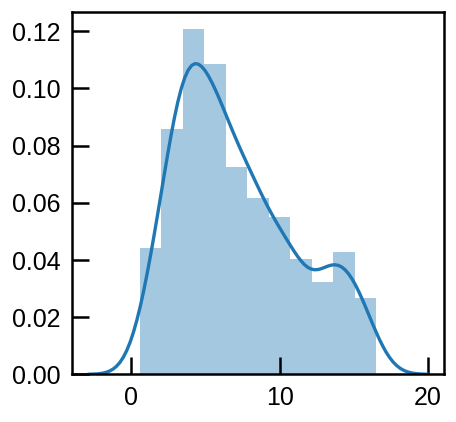

In [99]:
sns.distplot(dr)
dxarr = np.linspace(0, 10, 21)

In [65]:
# tmp = df_vanilla_dr2.loc[df_vanilla_dr2['radial_velocity'].notnull()].reset_index(drop=True)

In [66]:
df_vanilla_dr2= df_vanilla_dr2.drop(index=187).reset_index(drop=True)
df_vanilla_dr2= df_vanilla_dr2.drop(index=[34, 108, 151]).reset_index(drop=True)

In [72]:
df_vanilla_dr2 = df_vanilla_dr2.assign(
    vra_error=df_vanilla_dr2.g.vra_error,
    vdec_error=df_vanilla_dr2.g.vdec_error,
    inplace=True)

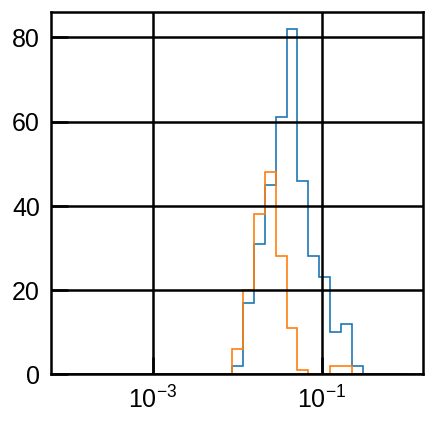

In [113]:
df_vanilla_dr2.groupby(df_vanilla_dr2["radial_velocity"].notnull())["vdec_error"].hist(
    bins=np.logspace(-4, 0, 32), histtype='step'
)
plt.gca().set_xscale('log');

In [75]:
%%time
m = kn.Fitter()
b0 = np.median(hy_dr2.g.icrs.cartesian.xyz.value, axis=1)
print(f"b0 = {b0}")

stanfit = m.fit(tmp, b0=b0)
azfit = az.from_pystan(stanfit)

INFO:kinesis.models:Reading model from disk


b0 = [17.26821532 41.64304963 13.606407  ]
CPU times: user 5.09 s, sys: 1.2 s, total: 6.28 s
Wall time: 2min


In [76]:
az.summary(azfit, var_names=['v0', 'sigv', 'T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.128,0.035,0.000,0.000,-6.194,-6.065,5538.0,5538.0,5510.0,3026.0,1.0
v0[1],45.691,0.042,0.001,0.000,45.613,45.769,5612.0,5612.0,5602.0,2853.0,1.0
v0[2],5.541,0.034,0.000,0.000,5.478,5.608,5506.0,5504.0,5501.0,2882.0,1.0
sigv,0.403,0.017,0.000,0.000,0.375,0.438,5519.0,5477.0,5553.0,3322.0,1.0
"T_param[0,0]",-14.807,11.041,0.170,0.131,-35.088,6.513,4216.0,3577.0,4218.0,3221.0,1.0
"T_param[0,1]",6.225,6.991,0.112,0.091,-6.991,19.229,3887.0,2922.0,3926.0,3006.0,1.0
"T_param[0,2]",3.521,8.855,0.136,0.128,-12.553,20.177,4255.0,2389.0,4267.0,3001.0,1.0
"T_param[1,0]",-16.960,14.388,0.218,0.181,-44.346,10.013,4353.0,3158.0,4371.0,3194.0,1.0
"T_param[1,1]",6.916,8.781,0.138,0.116,-8.781,23.446,4067.0,2862.0,4098.0,3113.0,1.0
"T_param[1,2]",11.108,11.454,0.184,0.145,-9.610,33.111,3866.0,3123.0,3855.0,3124.0,1.0


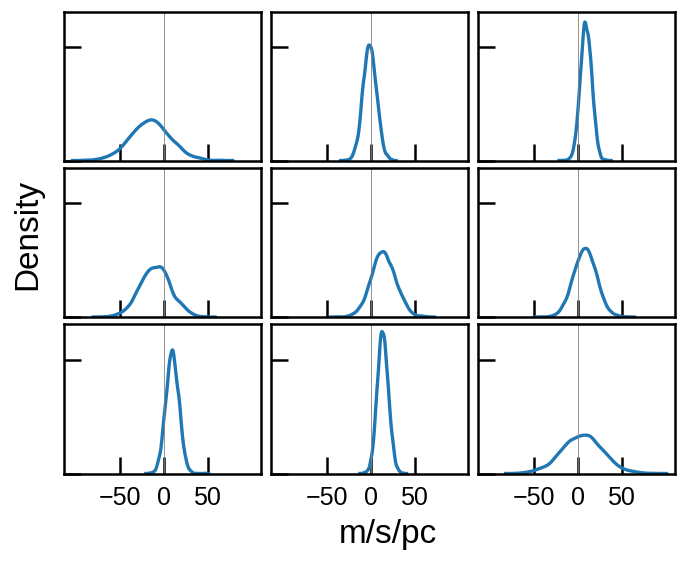

In [73]:
fig, ax = plt.subplots(3, 3, figsize=(6, 5), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.15, top=0.92, right=0.95, left=0.1, hspace=0.05, wspace=0.05)
ax = ax.ravel()
for cax, cT in zip(ax, stanfit['T_param'].reshape((-1, 9)).T):
#     cax.hist(cT, bins=32, density=True, histtype="step")
    sns.distplot(cT, hist=False, ax=cax)
    cax.axvline(0, c="gray", lw=0.5)
fig.text(0.55, 0.05, "m/s/pc", ha="center", va="center", size=20)
fig.text(0.05, 0.55, "Density", ha="center", va="center", rotation=90, size=20)
for cax in ax: cax.yaxis.set_major_formatter(ticker.NullFormatter())
for cax in ax: cax.set_xticks([-50, 0, 50])
# fig.suptitle("leao_dr2_harps_frcor $T$");
# fig.savefig("mock_posterior_T.png")

omega = 11.400932107253535 +- 5.368236808120433


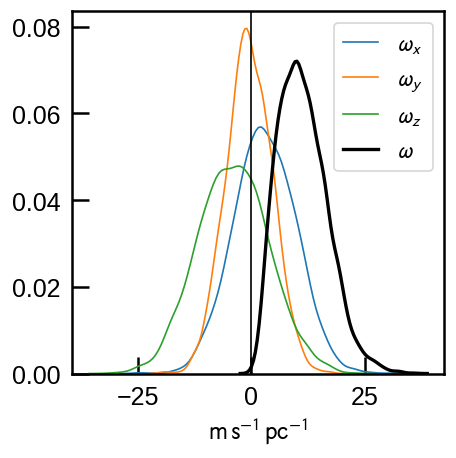

In [76]:
wT = decompose_T(stanfit["T_param"])
fig, ax = plt.subplots(figsize=(4,4))
sns.distplot(wT["omegax"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
sns.distplot(wT["omegay"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
sns.distplot(wT["omegaz"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
omega = np.sqrt(wT["omegax"] ** 2 + wT["omegay"] ** 2 + wT["omegaz"] ** 2)
print(f"omega = {np.mean(omega)} +- {np.std(omega)}")
sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
ax.axvline(0, c='k', lw=1)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\rm m\,\rm s^{-1}\,\rm pc^{-1}$');

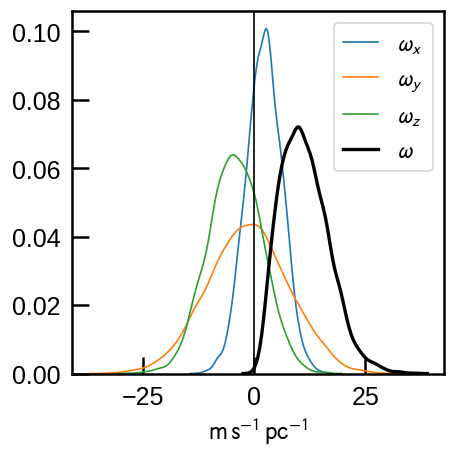

In [77]:
# hack rotation matrix from icrs -> galactic
rotmat = coord.ICRS(
    [1, 0, 0], [0, 1, 0], [0, 0, 1], representation_type=coord.CartesianRepresentation
).transform_to(coord.Galactic).cartesian.xyz.value

def rotate_T_to_galactic(T):
    """R T R^T"""
    rotated_T = np.einsum('ij,njk,kl->nil', rotmat, T, rotmat.T)
    return rotated_T

wT = decompose_T(rotate_T_to_galactic(stanfit["T_param"]))
fig, ax = plt.subplots(figsize=(4,4))
sns.distplot(wT["omegax"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
sns.distplot(wT["omegay"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
sns.distplot(wT["omegaz"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
omega = np.sqrt(wT["omegax"] ** 2 + wT["omegay"] ** 2 + wT["omegaz"] ** 2)
sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
ax.axvline(0, c='k', lw=1)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\rm m\,\rm s^{-1}\,\rm pc^{-1}$');

In [78]:
T_galactic = rotate_T_to_galactic(stanfit["T_param"])
# T_galactic = stanfit["T_param"]
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.
T_antisym = (T_galactic - np.transpose(T_galactic, (0, 2, 1))) / 2.

In [79]:
# math check
assert (
    (T_antisym[:, 2, 1] == decompose_T(T_galactic)["omegax"]).all(),
    (T_antisym[:, 0, 2] == decompose_T(T_galactic)["omegay"]).all(),
    (T_antisym[:, 1, 0] == decompose_T(T_galactic)["omegaz"]).all(),
) == (True, True, True)

In [80]:
w, v = np.linalg.eig(T_sym)

In [81]:
i_wsort = np.argsort(w, axis=1)
# my numpy-fu running out...
sorted_v = np.stack([v[j][:,i] for j, i in enumerate(i_wsort)])
sorted_w = np.sort(w, axis=1)

In [82]:
# verify math
assert np.allclose(sorted_w.mean(axis=1), decompose_T(T_galactic)["kappa"]) == True

In [83]:
plt.rc("figure", figsize=(4,4))

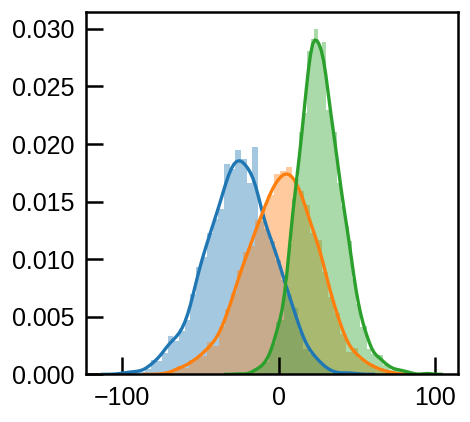

In [84]:
sns.distplot(sorted_w.T[0])
sns.distplot(sorted_w.T[1])
sns.distplot(sorted_w.T[2]);

In [57]:
np.nanmean(hy_dr2.g.galactic.velocity.d_z)

<Quantity -1.18647603 km / s>

In [54]:
hy_dr2.g.galactic.cartesian.xyz.mean(axis=1)

<Quantity [-44.44776064,   0.05072953, -16.78978432] pc>

In [8]:
(21*u.km/u.s/u.kpc).to(1./u.Myr)**2

<Quantity 0.00046126 1 / Myr2>

In [85]:
for cw in sorted_w.T:
    print(f"{np.mean(cw):8.3f} +- {np.std(cw):8.3f} ({np.abs(np.mean(cw)/np.std(cw)):8.3f})")

 -25.103 +-   21.738 (   1.155)
   2.044 +-   22.857 (   0.089)
  26.831 +-   14.532 (   1.846)


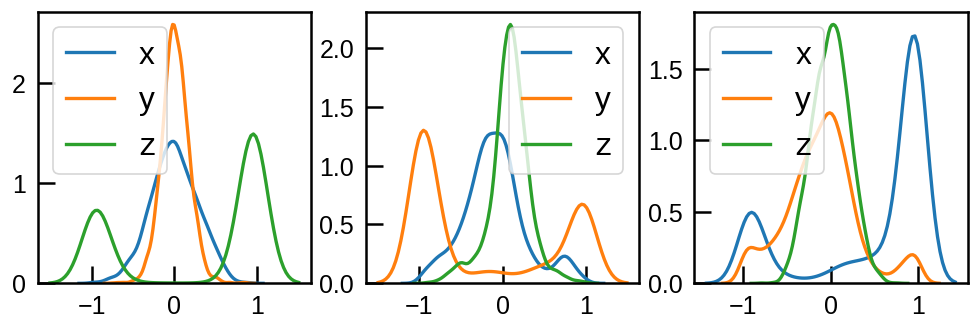

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for i in range(3):
    vd = pd.DataFrame(sorted_v[:,:,i], columns=['x','y','z'])
    for col in vd:
        sns.kdeplot(vd[col], ax=ax[i])

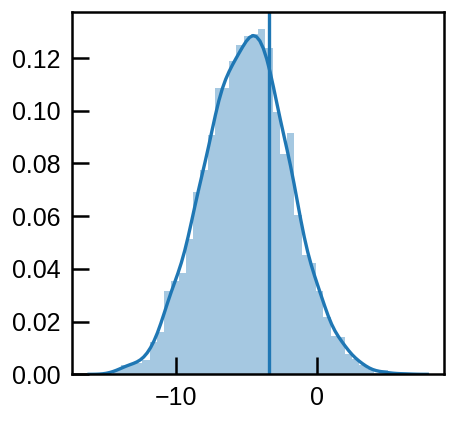

In [37]:
sns.distplot(T_galactic[:,1,0])
np.mean(T_galactic[:,1,0]), np.std(T_galactic[:,1,0])
plt.axvline(-3.4);

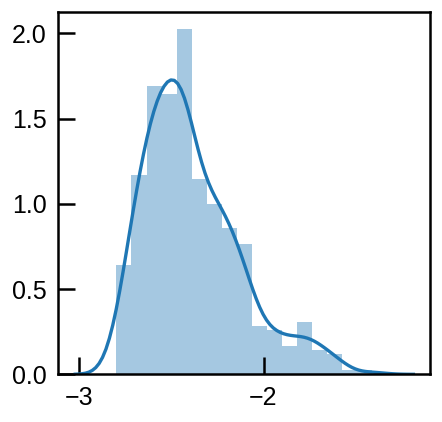

In [86]:
sns.distplot(np.log10(df_vanilla_dr2['parallax_error']/df_vanilla_dr2['parallax']))

In [82]:
df_vanilla_dr2 = df_vanilla_dr2.assign(
    icrs_x=df_vanilla_dr2.g.icrs.cartesian.x,
    icrs_y=df_vanilla_dr2.g.icrs.cartesian.y,
    icrs_z=df_vanilla_dr2.g.icrs.cartesian.z,
    gal_x=df_vanilla_dr2.g.galactic.cartesian.x,
    gal_y=df_vanilla_dr2.g.galactic.cartesian.y,
    gal_z=df_vanilla_dr2.g.galactic.cartesian.z,
)

In [97]:
x, y, z = df_vanilla_dr2.g.icrs.cartesian.xyz
dx, dy, dz = x-x.mean(), y-y.mean(), z-z.mean()
dr = np.sqrt(dx**2+dy**2+dz**2)

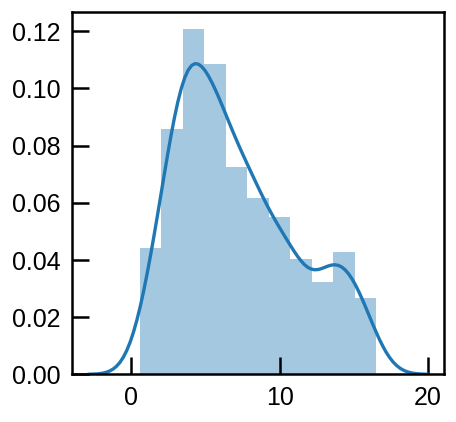

In [99]:
sns.distplot(dr)
dxarr = np.linspace(0, 10, 21)

In [108]:
df_vanilla_dr2[['gal_x', 'gal_y', 'gal_z']].describe()

,gal_x,gal_y,gal_z
count,515.000000,515.000000,515.000000
mean,-44.447761,0.050730,-16.789784
std,5.914090,4.623677,3.273785
min,-60.707233,-13.764624,-30.160668
25%,-47.632088,-2.747963,-19.064730
50%,-43.716060,0.153145,-16.992104
75%,-41.098669,2.990003,-14.624051
max,-29.199746,16.065538,-7.241971


In [111]:
tmp = df_vanilla_dr2[['gal_x', 'gal_y', 'gal_z']]

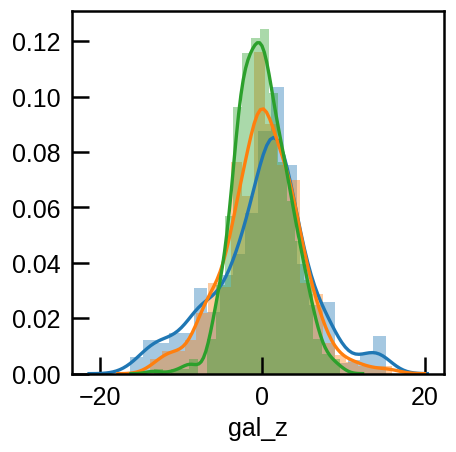

In [115]:
tmp.apply(lambda x: sns.distplot(x-np.mean(x)), axis=0);

ValueError: color kwarg must have one color per data set. 3 data sets and 1 colors were provided

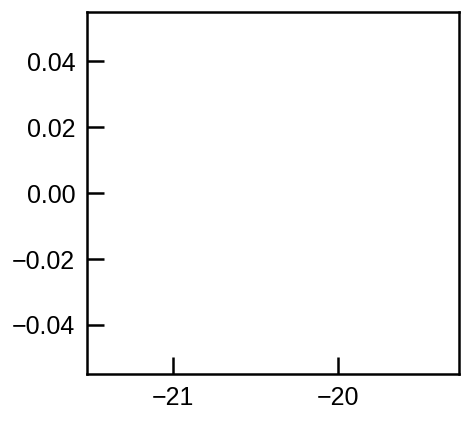

In [110]:
sns.distplot(df_vanilla_dr2[gal])

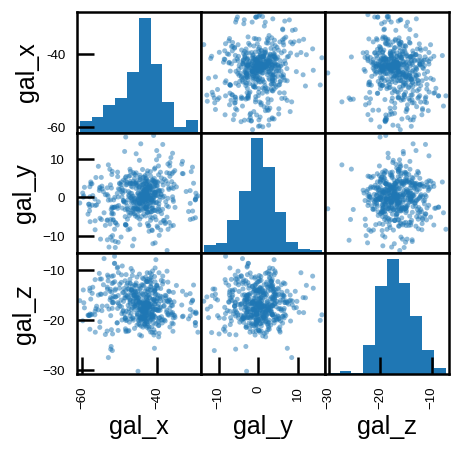

In [107]:
pd.plotting.scatter_matrix(df_vanilla_dr2[['gal_x', 'gal_y', 'gal_z']]);

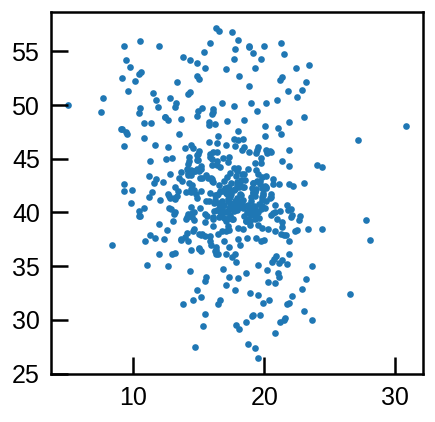

In [89]:
plt.scatter(df_vanilla_dr2.g.icrs.cartesian.x, df_vanilla_dr2.g.icrs.cartesian.y, s=9)

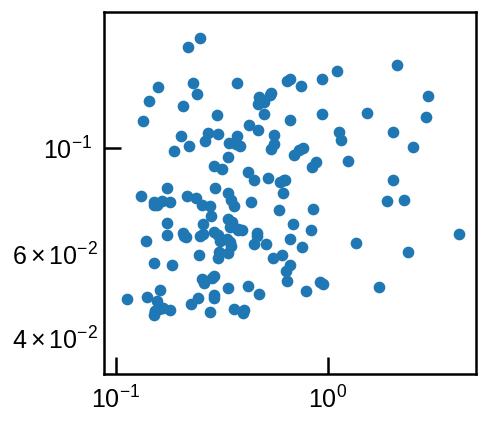

In [23]:
plt.scatter(stanfit.data['rv_error'], stanfit['rv_model'].std(axis=0))
plt.xscale('log')
plt.yscale('log');
x=np.logspace(-1,2)
# plt.plot(x, x, 'k-');

In [96]:
delta_rv = (stanfit.data['rv'][None,:] - stanfit['rv_model']) / np.hypot(stanfit.data['rv_error'][None,:], stanfit['sigv'][:,None])
delta_rv1 = (stanfit.data['rv'][None,:] - stanfit['rv_model']) / stanfit.data['rv_error'][None,:]
delta_rv2 = (stanfit.data['rv'][None,:] - stanfit['rv_model'])

In [97]:
mean_delta_rv = np.mean(delta_rv, axis=0)
std_delta_rv = np.std(delta_rv, axis=0)

In [98]:
import scipy as sp

In [99]:
df_vanilla_dr2.loc[(mean_delta_rv>3)]

,ra,dec,phot_g_mean_mag,parallax,pmra,pmdec,parallax_error,pmra_error,pmdec_error,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,radial_velocity,radial_velocity_error,vra_error,vdec_error,inplace
34,68.189623,12.066609,13.763806,20.549995,96.952515,-14.186060,0.056649,0.105020,0.069763,0.289357,0.340846,-0.143548,NaN,NaN,0.066241,0.018449,True
107,62.776044,18.928968,14.218579,19.731306,109.682796,-28.682527,0.083520,0.145464,0.106822,0.285022,0.224602,0.270783,NaN,NaN,0.116889,0.038852,True
150,59.809805,22.043668,12.076345,24.631610,148.483728,-43.928374,0.050212,0.093806,0.059589,0.095349,-0.128552,0.333687,34.406036,0.317873,0.060987,0.020701,True


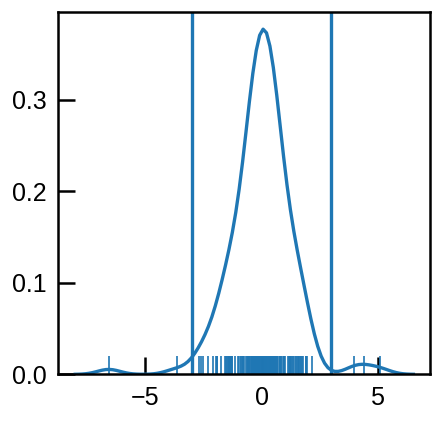

In [100]:
sns.distplot(mean_delta_rv, hist=False, rug=True);
# plt.plot(x, px, 'k-');
plt.axvline(-3)
plt.axvline(3);

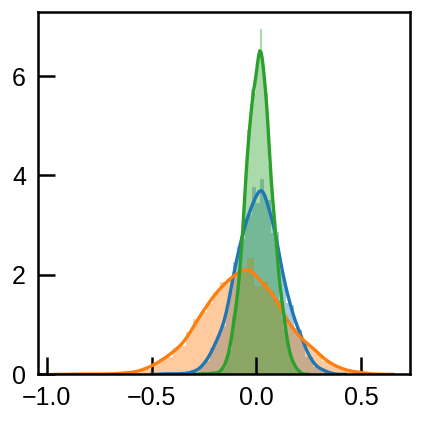

In [101]:
sns.distplot(delta_rv.mean(axis=1))
sns.distplot(delta_rv1.mean(axis=1));
sns.distplot(delta_rv2.mean(axis=1));

In [339]:
stanfit.data['irv'][stanfit.data['rv'].argsort()[0]]

187

In [355]:
hy_dr2['ruwe'][187]

1.2597213587987073

In [340]:
df_vanilla_dr2.iloc[187]

ra                       78.714192
dec                      17.787029
phot_g_mean_mag          13.499721
parallax                 17.602923
pmra                     54.276757
pmdec                   -27.363508
parallax_error            0.053941
pmra_error                0.081767
pmdec_error               0.062659
parallax_pmra_corr        0.306982
parallax_pmdec_corr       0.412306
pmra_pmdec_corr           0.060959
radial_velocity          16.515485
radial_velocity_error     2.967589
Name: 187, dtype: float64

In [44]:
hy_dr2 = gp.add_ruwe(hy_dr2)
hy_dr2 = hy_dr2.assign(
    icrs_vx=hy_dr2.g.icrs.velocity.d_x,
    icrs_vy=hy_dr2.g.icrs.velocity.d_y,
    icrs_vz=hy_dr2.g.icrs.velocity.d_z,
)

In [43]:
np.median(stanfit.data['rv_error'])

0.3576707490845559

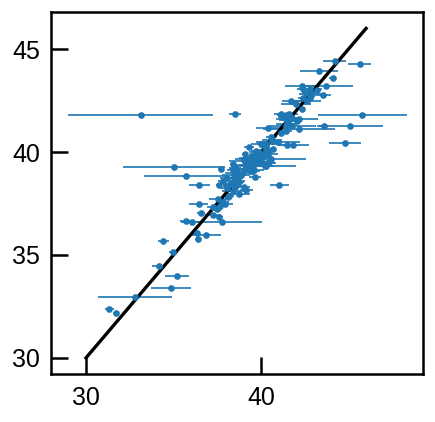

In [86]:
plt.errorbar(stanfit.data['rv'], stanfit['rv_model'].mean(axis=0), xerr=stanfit.data['rv_error'], ls='None', marker='.', elinewidth=1);
x = np.linspace(30,46)
plt.plot(x,x, c='k')

In [42]:
plt.errorbar(np.arange(len(mean_delta_rv)), mean_delta_rv, yerr=std_delta_rv, marker='.', ls='None');

NameError: name 'mean_delta_rv' is not defined

In [267]:
D = stanfit.data['C'].copy()
D[:,1, 1] += stanfit['sigv']**2 / stanfit['d']

(515, 3, 3)

In [266]:
delta = stanfit.data['a'][None,:,:] - stanfit['a_model']


(515, 3)

In [265]:
stan
stanfit['a_model']

(4000, 515, 3)

In [70]:
w

array([ 29.91438517, -34.74085269, -11.59109153])

In [71]:
v

array([[ 0.96295271, -0.201319  , -0.17942336],
       [-0.21827389, -0.19115022, -0.95698386],
       [-0.15836222, -0.96069363,  0.2280113 ]])

In [37]:
asser

array([ -3.13993333,   9.42527047,  -4.21650099, ...,  -7.10194253,
       -10.08935932,   4.42523089])

In [264]:
# results will be saved here
stanfit = {}
azfit = {}

# potential hessians

In [27]:
from gala.potential import MilkyWayPotential
pot = MilkyWayPotential(halo=dict(c=1.)) # make it spherical


In [28]:
pot.hessian([0, 8., 0] * u.kpc)

<Quantity [[[ 0.00044584],
            [ 0.        ],
            [ 0.        ]],

           [[ 0.        ],
            [-0.00072027],
            [ 0.        ]],

           [[ 0.        ],
            [ 0.        ],
            [ 0.00551634]]] 1 / Myr2>

In [29]:
pot.hessian([8, 0., 0] * u.kpc)

<Quantity [[[-0.00072027],
            [ 0.        ],
            [ 0.        ]],

           [[ 0.        ],
            [ 0.00044584],
            [ 0.        ]],

           [[ 0.        ],
            [ 0.        ],
            [ 0.00551634]]] 1 / Myr2>

In [47]:
hess = pot.hessian([8,0, 0] * u.kpc)

In [48]:
hess

<Quantity [[[-0.00072027],
            [ 0.        ],
            [ 0.        ]],

           [[ 0.        ],
            [ 0.00044584],
            [ 0.        ]],

           [[ 0.        ],
            [ 0.        ],
            [ 0.00551634]]] 1 / Myr2>

In [45]:
hy_dr2.g.galactic.cartesian.z.mean()

<Quantity -16.78978432 pc>

In [46]:
nz = hess.ravel()[hess.ravel() != 0]
(np.sign(nz) * np.sqrt(np.abs(nz))).to(u.km/u.s/u.kpc)

<Quantity [-26.24192665,  20.646093  ,  72.62261898] km / (kpc s)>

In [49]:
72.6/26.2

2.7709923664122136

## Fit: Leao DR2 + HARPS RV + frame rotation correction

In [265]:
%%time
m = kn.Fitter()
b0 = np.median(df['leao_dr2_harps'].g.icrs.cartesian.xyz.value, axis=1)

for k, d in df.items():
    stanfit[k] = m.fit(df[k], b0=b0)

INFO:kinesis.models:Reading model from disk


CPU times: user 4.16 s, sys: 3.09 s, total: 7.25 s
Wall time: 1min 53s


In [266]:
for k, v in stanfit.items():
    azfit[k] = az.from_pystan(v)

In [269]:
azfit.keys()

dict_keys(['leao_dr2_harps', 'leao_dr2_harps_frcor'])

In [318]:
(20*u.m/u.s/u.pc).to(u.mas/u.yr, equivalencies=u.equivalencies.dimensionless_angles())

<Quantity 4.21899053 mas / yr>

In [316]:
((u.m/u.pc).decompose() * (u.yr/u.s).decompose() * u.rad.to(u.mas)).decompose()

<Quantity 0.21094953>

In [328]:
az.summary(azfit['leao_dr2_harps'], var_names=['v0', 'sigv'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.118,0.041,0.001,0.0,-6.193,-6.039,3779.0,3779.0,3787.0,2825.0,1.0
v0[1],45.792,0.042,0.001,0.0,45.710,45.870,3703.0,3703.0,3690.0,2531.0,1.0
v0[2],5.597,0.041,0.001,0.0,5.521,5.674,3692.0,3689.0,3699.0,2473.0,1.0
sigv,0.321,0.018,0.000,0.0,0.288,0.355,3764.0,3758.0,3733.0,2835.0,1.0


In [329]:
az.summary(azfit['leao_dr2_harps_frcor'], var_names=['v0', 'sigv'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.119,0.042,0.001,0.0,-6.201,-6.043,4266.0,4262.0,4230.0,3016.0,1.0
v0[1],45.792,0.041,0.001,0.0,45.713,45.868,4657.0,4657.0,4676.0,3056.0,1.0
v0[2],5.602,0.042,0.001,0.0,5.520,5.680,4600.0,4600.0,4591.0,2736.0,1.0
sigv,0.320,0.018,0.000,0.0,0.289,0.356,3998.0,3975.0,3977.0,2434.0,1.0


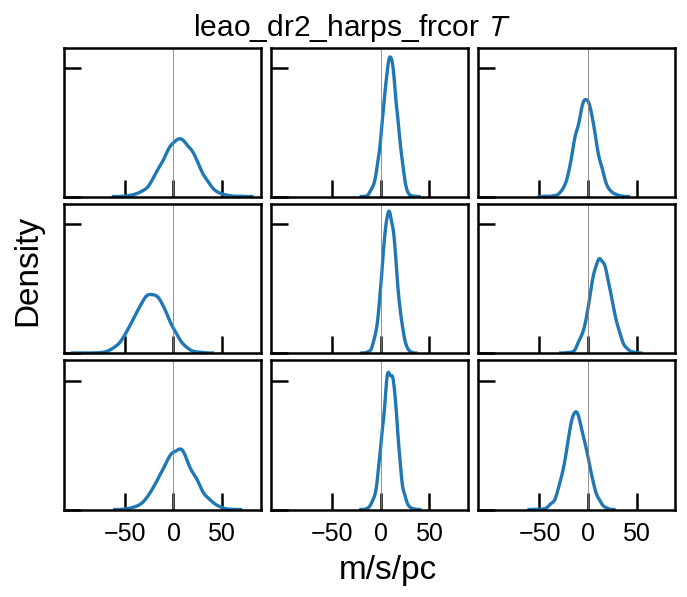

In [360]:
fig, ax = plt.subplots(3, 3, figsize=(6, 5), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.15, top=0.92, right=0.95, left=0.1, hspace=0.05, wspace=0.05)
ax = ax.ravel()
for cax, cT in zip(ax, stanfit['leao_dr2_harps_frcor']['T_param'].reshape((-1, 9)).T):
#     cax.hist(cT, bins=32, density=True, histtype="step")
    sns.distplot(cT, hist=False, ax=cax)
    cax.axvline(0, c="gray", lw=0.5)
fig.text(0.55, 0.05, "m/s/pc", ha="center", va="center", size=20)
fig.text(0.05, 0.55, "Density", ha="center", va="center", rotation=90, size=20)
for cax in ax: cax.yaxis.set_major_formatter(ticker.NullFormatter())
for cax in ax: cax.set_xticks([-50, 0, 50])
fig.suptitle("leao_dr2_harps_frcor $T$");
# fig.savefig("mock_posterior_T.png")

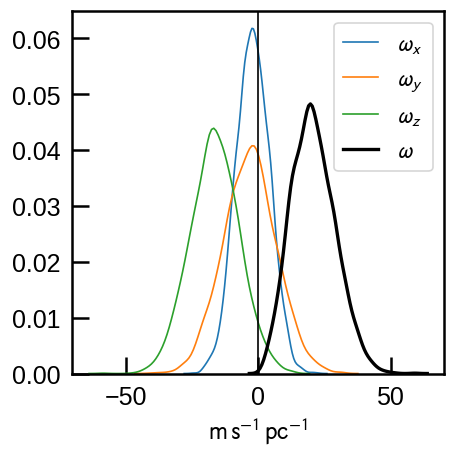

In [376]:
wT = decompose_T(stanfit["leao_dr2_harps_frcor"]["T_param"])
fig, ax = plt.subplots()
sns.distplot(wT["omegax"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
sns.distplot(wT["omegay"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
sns.distplot(wT["omegaz"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
omega = np.sqrt(wT["omegax"] ** 2 + wT["omegay"] ** 2 + wT["omegaz"] ** 2)
sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
ax.axvline(0, c='k', lw=1)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\rm m\,\rm s^{-1}\,\rm pc^{-1}$');

In [209]:
# hack rotation matrix from icrs -> galactic
coord.ICRS(
    1,0,0, representation_type=coord.CartesianRepresentation
).transform_to(coord.Galactic).cartesian.xyz.value

array([-0.05487566,  0.49410944, -0.86766614])

In [378]:
# hack rotation matrix from icrs -> galactic
rotmat = coord.ICRS(
    [1, 0, 0], [0, 1, 0], [0, 0, 1], representation_type=coord.CartesianRepresentation
).transform_to(coord.Galactic).cartesian.xyz.value

def rotate_T_to_galactic(T):
    """R T R^T"""
    rotated_T = np.einsum('ij,njk,kl->nil', rotmat, T, rotmat.T)
    return rotated_T

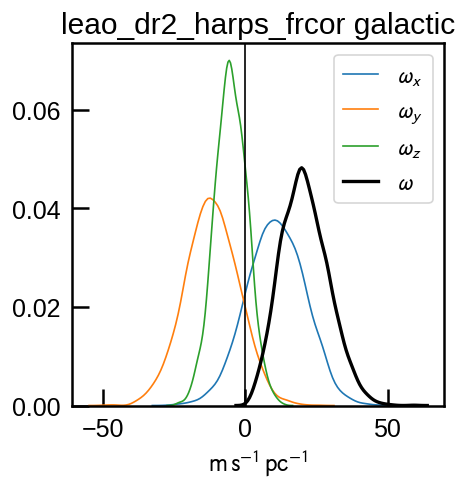

In [381]:
wT = decompose_T(rotate_T_to_galactic(stanfit["leao_dr2_harps_frcor"]["T_param"]))
fig, ax = plt.subplots()
sns.distplot(wT["omegax"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
sns.distplot(wT["omegay"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
sns.distplot(wT["omegaz"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
omega = np.sqrt(wT["omegax"] ** 2 + wT["omegay"] ** 2 + wT["omegaz"] ** 2)
sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
ax.axvline(0, c='k', lw=1)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\rm m\,\rm s^{-1}\,\rm pc^{-1}$');
ax.set_title("leao_dr2_harps_frcor galactic");

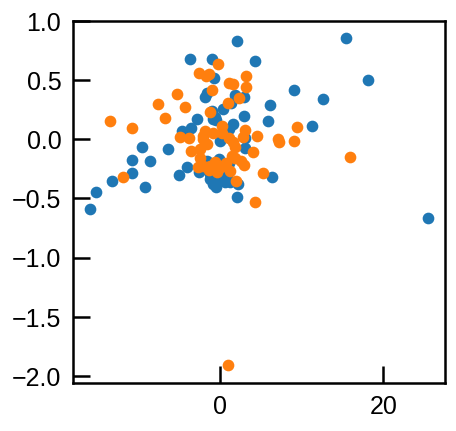

In [243]:
plt.scatter(
    df_leao_gaia_harps.g.galactic.cartesian.x
    - df_leao_gaia_harps.g.galactic.cartesian.x.mean(),
    df_leao_gaia_harps.g.galactic.velocity.d_x
    - df_leao_gaia_harps.g.galactic.velocity.d_x.mean(),
)
plt.scatter(
    df_leao_gaia_harps.g.galactic.cartesian.y
    - df_leao_gaia_harps.g.galactic.cartesian.y.mean(),
    df_leao_gaia_harps.g.galactic.velocity.d_y
    - df_leao_gaia_harps.g.galactic.velocity.d_y.mean(),
)

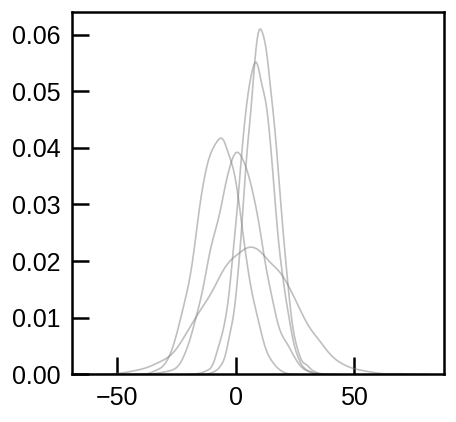

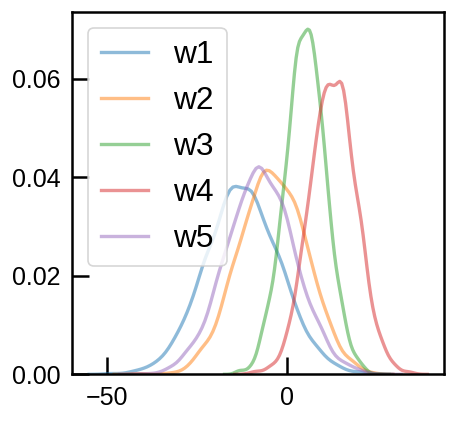

In [408]:
wT = decompose_T(stanfit["leao_dr2_harps_frcor"]["T_param"])
for key in ['w1','w2','w3','w4','w5']:
    sns.distplot(wT[key], hist=False, color='gray', kde_kws={'alpha':.5, 'lw':1})
plt.figure()
wT = decompose_T(rotate_T_to_galactic(stanfit["leao_dr2_harps_frcor"]["T_param"]))
for key in ['w1','w2','w3','w4','w5']:
    sns.distplot(wT[key], hist=False, kde_kws={'alpha':.5, 'lw':2}, label=key)
# sns.distplot(wT['w1'], hist=False,);
plt.legend()

In [123]:
# %%time
# stanfit_repeat = [m.fit(df, b0=b0) for i in range(5)]

CPU times: user 11.2 s, sys: 8.52 s, total: 19.7 s
Wall time: 5min 49s


### Fit Leao HARPS incl. one obvious outlier

In [392]:
%%time
b0 = np.median(df['leao_dr2_harps'].g.icrs.cartesian.xyz.value, axis=1)
stanfit['leao_incl_outlier'] = m.fit(df['leao_incl_outlier'], b0=b0)

CPU times: user 2.08 s, sys: 1.86 s, total: 3.94 s
Wall time: 57.4 s


In [394]:
azfit['leao_incl_outlier'] = az.from_pystan(stanfit['leao_incl_outlier'])

In [396]:
az.summary(azfit['leao_incl_outlier'], var_names=['v0', 'sigv'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.150,0.081,0.001,0.001,-6.293,-5.991,3273.0,3273.0,3285.0,2664.0,1.0
v0[1],45.818,0.080,0.001,0.001,45.662,45.958,2958.0,2958.0,2957.0,2533.0,1.0
v0[2],5.561,0.081,0.001,0.001,5.412,5.710,3848.0,3848.0,3852.0,2709.0,1.0
sigv,0.620,0.035,0.001,0.000,0.555,0.686,2726.0,2695.0,2770.0,2175.0,1.0
"T_param[0,0]",76.520,31.930,0.608,0.430,17.469,137.502,2756.0,2756.0,2759.0,2685.0,1.0
"T_param[0,1]",29.450,13.391,0.250,0.179,5.443,56.016,2863.0,2793.0,2866.0,2690.0,1.0
"T_param[0,2]",-46.145,19.527,0.338,0.245,-81.519,-8.386,3331.0,3184.0,3331.0,3009.0,1.0
"T_param[1,0]",-80.188,30.799,0.601,0.425,-140.132,-24.872,2629.0,2629.0,2627.0,2869.0,1.0
"T_param[1,1]",-7.405,13.452,0.252,0.194,-32.201,18.424,2851.0,2394.0,2840.0,2663.0,1.0
"T_param[1,2]",48.056,19.031,0.336,0.244,11.585,82.693,3217.0,3051.0,3212.0,3040.0,1.0


# Fit 1:

In [109]:
v = df.g.icrs.velocity.d_xyz.value
meanv = np.mean(v, axis=1)
stdv = np.std(v, axis=1)
print(meanv, stdv)

for dvmax in [1, 2, 3, 4]:
    i_outlier = np.where((np.abs(v - meanv[:, None]) > dvmax).any(axis=0))[0]
    print("dvmax = {:.0f} outliers: {}".format(dvmax, i_outlier))

[-6.764637   46.10483862  5.39174494] [4.91903026 2.55830459 1.0903349 ]
dvmax = 1 outliers: [ 1  4  7  8 13 14 18 25 33 35 37 40 41 42 51 64 65]
dvmax = 2 outliers: [37 42 51]
dvmax = 3 outliers: [42 51]
dvmax = 4 outliers: [42 51]


In [110]:
df.iloc[[42,51]][['hip', 'pmra_hip', 'pmdec_hip', 'pmra_gaia', 'pmdec_gaia', 'pmra', 'pmdec', 'parallax']]

,hip,pmra_hip,pmdec_hip,pmra_gaia,pmdec_gaia,pmra,pmdec,parallax
42,20605,102.00535,-23.607138,121.402626,-17.822027,102.99641,-19.213434,6.964943
51,22271,111.32195,-82.115660,113.234500,-83.790245,113.52807,-83.943800,21.003447


In [111]:
plt.rc('figure', figsize=(4,3))

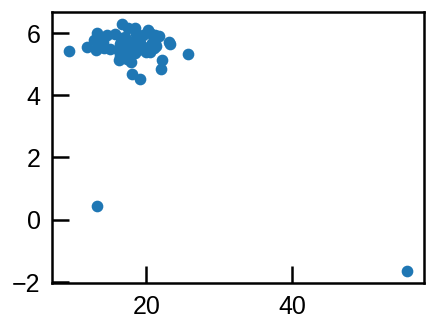

In [112]:
plt.scatter(df.g.icrs.cartesian.x, df.g.icrs.velocity.d_xyz.value[2])

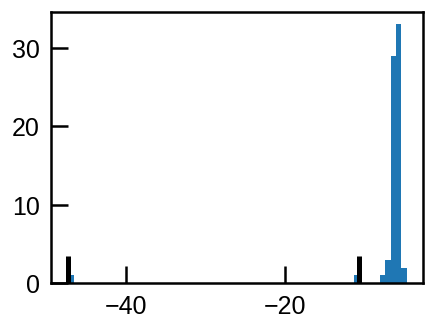

In [113]:
plt.hist(v[0], 64);
sns.rugplot(v[0][i_outlier], height=0.1, color='k', lw=3);

In [114]:
df = df.drop(index=[42 ,51]).reset_index(drop=True)

In [116]:
m = kn.Fitter()
b0 = np.median(df.g.icrs.cartesian.xyz.value, axis=1)
map_ = m.fit(df, b0=b0, sample=False)

print(f"{map_['v0']} {map_['sigv']}")
decompose_T(map_['T_param'])

INFO:kinesis.models:Reading model from disk


[-6.09826969 45.74696898  5.57642496] 0.3682992163008648


{'omegax': array([1.72124271]),
 'omegay': array([0.8465971]),
 'omegaz': array([-7.11146248]),
 'w1': array([7.01095467]),
 'w2': array([-0.99875953]),
 'w3': array([-1.13823261]),
 'w4': array([0.17343705]),
 'w5': array([18.11797357]),
 'kappa': array([4.46247205])}

In [117]:
%%time
stanfit = m.fit(df, b0=b0, sample_file='hy_hg_harps.stanfit')

CPU times: user 2.23 s, sys: 1.33 s, total: 3.56 s
Wall time: 1min 7s


In [123]:
%%time
stanfit_repeat = [m.fit(df, b0=b0) for i in range(5)]

CPU times: user 11.2 s, sys: 8.52 s, total: 19.7 s
Wall time: 5min 49s


In [118]:
azfit = az.from_pystan(stanfit)

In [119]:
az.summary(azfit, var_names=['v0', 'sigv', 'T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.098,0.048,0.001,0.001,-6.191,-6.009,4220.0,4216.0,4227.0,2953.0,1.0
v0[1],45.740,0.047,0.001,0.001,45.651,45.828,4300.0,4300.0,4332.0,2705.0,1.0
v0[2],5.579,0.047,0.001,0.000,5.491,5.671,4716.0,4714.0,4716.0,2958.0,1.0
sigv,0.385,0.020,0.000,0.000,0.347,0.422,4699.0,4669.0,4695.0,3270.0,1.0
"T_param[0,0]",6.144,19.816,0.361,0.286,-31.802,43.040,3012.0,2405.0,3029.0,2891.0,1.0
"T_param[0,1]",7.090,8.228,0.150,0.109,-8.379,22.173,2993.0,2837.0,3001.0,3014.0,1.0
"T_param[0,2]",-3.000,12.343,0.207,0.176,-26.617,20.587,3539.0,2460.0,3552.0,2916.0,1.0
"T_param[1,0]",-27.665,19.915,0.332,0.244,-66.318,8.374,3600.0,3341.0,3605.0,2893.0,1.0
"T_param[1,1]",11.779,8.340,0.145,0.107,-4.492,26.874,3324.0,3030.0,3328.0,2946.0,1.0
"T_param[1,2]",11.343,12.013,0.196,0.153,-9.883,34.113,3742.0,3077.0,3742.0,3187.0,1.0


Text(0.05, 0.55, 'Density')

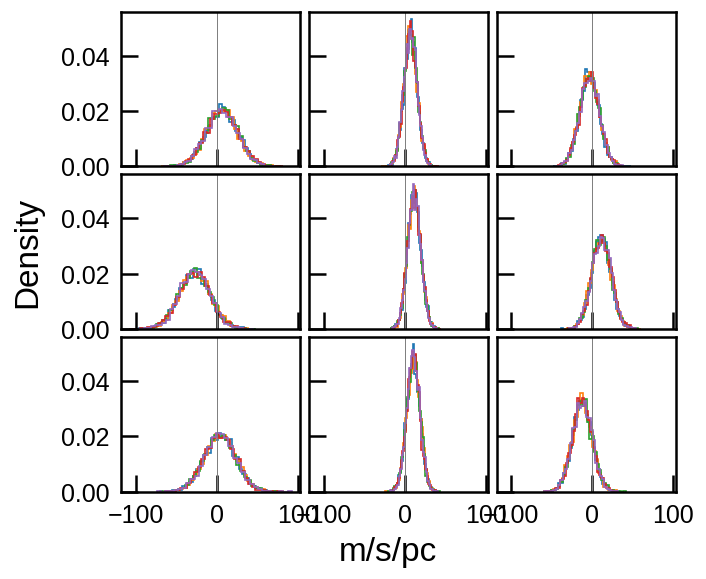

In [124]:
fig, ax = plt.subplots(3, 3, figsize=(6, 5), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95, left=0.18, hspace=0.05, wspace=0.05)
ax = ax.ravel()

for ff in stanfit_repeat:
    for cax, cT in zip(ax, ff["T_param"].reshape((-1, 9)).T):
        cax.hist(cT, bins=32, density=True, histtype="step")
        cax.axvline(0, c="gray", lw=0.5)
fig.text(0.55, 0.05, "m/s/pc", ha="center", va="center", size=20)
fig.text(0.05, 0.55, "Density", ha="center", va="center", rotation=90, size=20)
# fig.savefig("mock_posterior_T.png")

In [127]:
wT = decompose_T(stanfit["T_param"])

In [133]:
desc = pd.DataFrame(wT).describe()
desc.loc['mean/std'] = desc.loc['mean']/desc.loc['std']
desc

,omegax,omegay,omegaz,w1,w2,w3,w4,w5,kappa
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.126194,-3.657299,-17.377249,11.217130,0.657567,-10.287506,6.143657,11.778682,1.779266
std,7.411063,11.596351,10.760561,7.104028,11.566016,10.790342,19.818557,8.340962,8.209324
min,-29.279602,-39.692252,-60.480495,-22.222959,-35.999355,-50.793540,-58.799341,-17.892106,-27.360801
25%,-5.107607,-11.729396,-24.604479,6.488098,-7.385048,-17.624446,-7.105662,6.164626,-3.796174
50%,-0.111068,-3.688308,-17.367419,11.271062,0.794647,-10.100904,6.387156,11.820619,1.679525
75%,4.693462,4.125693,-10.099249,15.987786,8.524310,-2.832639,19.285254,17.399770,7.298822
max,28.264766,38.792146,18.858019,38.605357,46.680300,25.550656,75.570581,37.678091,30.840688
mean/std,-0.017028,-0.315384,-1.614902,1.578982,0.056853,-0.953399,0.309995,1.412149,0.216737


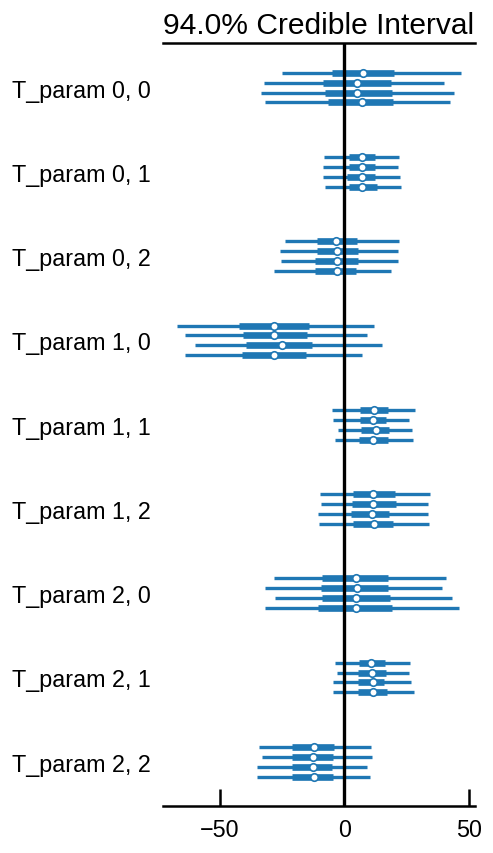

In [134]:
o = az.plot_forest(azfit, var_names=['T_param'], figsize=(4,7))
o[1][0].axvline(0, c='k');

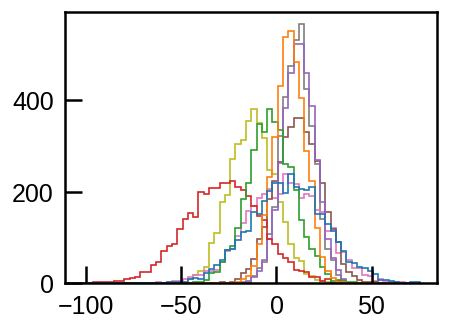

In [135]:
plt.hist(stanfit['T_param'].reshape((-1,9)), bins=64, histtype='step');

In [408]:
import astropy.coordinates as coord

c0 = coord.ICRS(x=0,y=0,z=1, representation_type='cartesian').transform_to(coord.Galactic)
c0, c0.cartesian

(<Galactic Coordinate: (l, b, distance) in (deg, deg, )
     (122.93192526, 27.12825241, 1.)>,
 <CartesianRepresentation (x, y, z) [dimensionless]
     (-0.48383507, 0.74698218, 0.45598381)>)

In [390]:
pd.DataFrame(wT).describe()

,omegax,omegay,omegaz,w1,w2,w3,w4,w5,kappa
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.174461,-3.736200,-16.891482,11.064576,0.554909,-9.658413,6.131068,12.099596,1.867577
std,7.364730,11.436398,10.529781,7.136150,11.587977,10.531619,19.401833,8.193046,8.082871
min,-26.730399,-40.223910,-54.530485,-15.905075,-36.798504,-51.426335,-68.789540,-17.058805,-27.319059
25%,-5.171749,-11.220050,-23.844344,6.265720,-7.214364,-16.910373,-7.042843,6.569874,-3.890439
50%,-0.155787,-3.599979,-16.883328,11.190426,0.721397,-9.697106,6.308021,12.097822,1.844222
75%,4.633083,3.692270,-9.757977,15.830815,8.022464,-2.533576,19.385120,17.588782,7.504419
max,24.885897,33.487211,24.747914,33.846505,41.210788,25.054664,70.460264,40.964871,30.139670


In [393]:
dd = az.summary(stanfit, var_names=['v0', 'sigv', 'T_param'], round_to=8)

In [394]:
dd['mean']/dd['sd']

v0[0]          -126.460430
v0[1]           967.713213
v0[2]           113.104572
sigv             18.759280
T_param[0,0]      0.316044
T_param[0,1]      0.885777
T_param[0,2]     -0.259857
T_param[1,0]     -1.367767
T_param[1,1]      1.476997
T_param[1,2]      0.932772
T_param[2,0]      0.220090
T_param[2,1]      1.349767
T_param[2,2]     -1.053280
dtype: float64

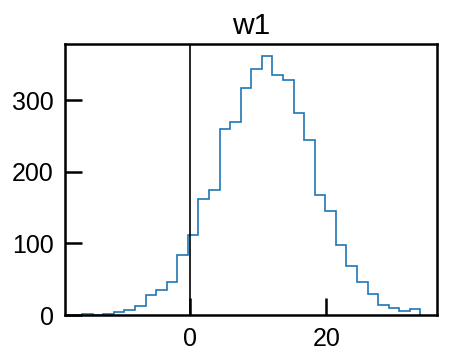

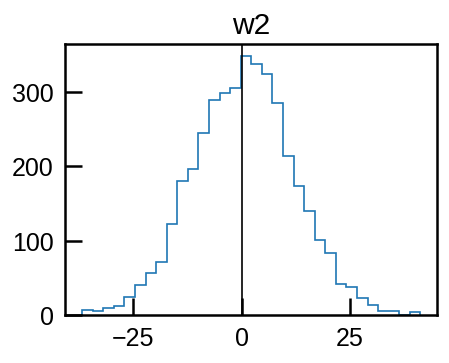

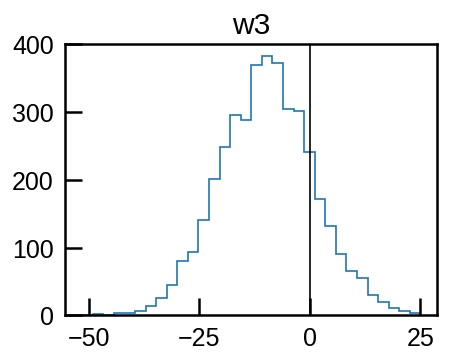

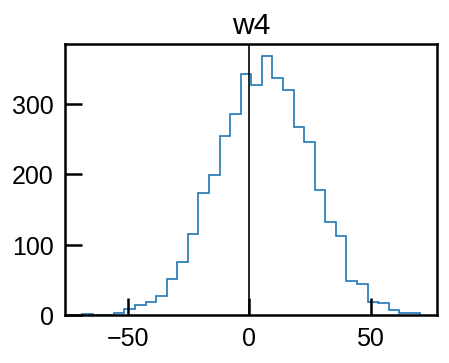

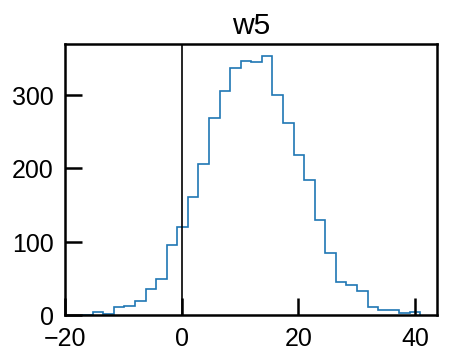

In [396]:
for par in ['w1', 'w2', 'w3', 'w4', 'w5']:
    plt.figure(figsize=(4,3))
    plt.hist(wT[par], 32, histtype='step');
    plt.title(par)
    plt.axvline(0, c='k', lw=1)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  2.,  4., 32., 56.,
        30., 19.,  5.,  1.,  1.,  2.]),
 array([-1.97160308, -1.67975278, -1.38790247, -1.09605217, -0.80420187,
        -0.51235157, -0.22050126,  0.07134904,  0.36319934,  0.65504965,
         0.94689995,  1.23875025,  1.53060055,  1.82245086,  2.11430116,
         2.40615146,  2.69800177,  2.98985207,  3.28170237,  3.57355267,
         3.86540298,  4.15725328,  4.44910358,  4.74095389,  5.03280419,
         5.32465449,  5.61650479,  5.9083551 ,  6.2002054 ,  6.4920557 ,
         6.78390601,  7.07575631,  7.36760661]),
 <a list of 32 Patch objects>)

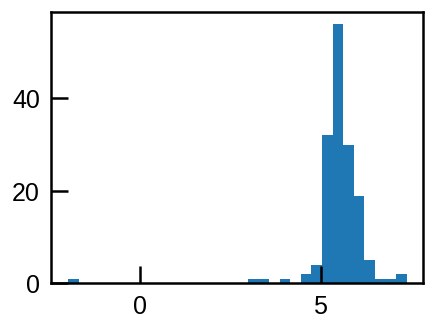

In [148]:
plt.hist(hy_dr2.g.icrs.velocity.d_xyz.value[2], 32)

In [428]:
%%time
stanfit_dr2 = m.fit(hy_dr2, b0=b0)  # same b0 for comparison

CPU times: user 14.9 s, sys: 3.13 s, total: 18.1 s
Wall time: 9min 36s


In [429]:
azfit_hy = az.from_pystan(stanfit_hy)

In [435]:
az.summary(azfit, var_names=['v0','sigv','T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.098,0.048,0.001,0.001,-6.185,-6.003,3004.0,3004.0,3019.0,2376.0,1.0
v0[1],45.741,0.047,0.001,0.001,45.647,45.827,3856.0,3856.0,3856.0,2994.0,1.0
v0[2],5.580,0.049,0.001,0.001,5.489,5.674,3495.0,3488.0,3488.0,2527.0,1.0
sigv,0.385,0.021,0.000,0.000,0.347,0.423,2913.0,2864.0,2993.0,2387.0,1.0
"T_param[0,0]",6.131,19.399,0.366,0.259,-31.830,39.891,2805.0,2805.0,2846.0,3180.0,1.0
"T_param[0,1]",7.233,8.166,0.146,0.106,-7.731,22.437,3129.0,2954.0,3138.0,3136.0,1.0
"T_param[0,2]",-3.181,12.242,0.221,0.189,-26.507,19.462,3059.0,2110.0,3043.0,2794.0,1.0
"T_param[1,0]",-26.550,19.411,0.375,0.265,-61.080,11.545,2683.0,2683.0,2682.0,2524.0,1.0
"T_param[1,1]",12.100,8.192,0.155,0.113,-3.079,27.448,2805.0,2634.0,2806.0,2741.0,1.0
"T_param[1,2]",11.239,12.049,0.220,0.163,-10.034,35.091,2998.0,2736.0,3017.0,2584.0,1.0


In [434]:
az.summary(azfit_hy, var_names=['v0','sigv','T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.098,0.027,0.001,0.000,-6.146,-6.047,2241.0,2241.0,2238.0,2596.0,1.0
v0[1],45.638,0.042,0.001,0.001,45.558,45.715,2119.0,2119.0,2118.0,2831.0,1.0
v0[2],5.529,0.023,0.000,0.000,5.487,5.575,2414.0,2413.0,2410.0,2904.0,1.0
sigv,0.393,0.009,0.000,0.000,0.375,0.410,3535.0,3535.0,3535.0,2977.0,1.0
"T_param[0,0]",-16.646,7.063,0.164,0.116,-30.651,-4.343,1859.0,1859.0,1865.0,2687.0,1.0
"T_param[0,1]",-2.323,4.440,0.103,0.073,-10.373,6.304,1852.0,1852.0,1849.0,2668.0,1.0
"T_param[0,2]",9.236,5.500,0.117,0.083,-1.041,19.310,2206.0,2206.0,2206.0,2735.0,1.0
"T_param[1,0]",-10.409,12.943,0.309,0.218,-35.357,14.052,1760.0,1760.0,1760.0,2413.0,1.0
"T_param[1,1]",10.571,7.846,0.182,0.129,-4.172,25.241,1862.0,1862.0,1862.0,2067.0,1.0
"T_param[1,2]",7.913,9.747,0.216,0.152,-10.512,25.544,2046.0,2046.0,2052.0,2656.0,1.0


Text(0.05, 0.55, 'Density')

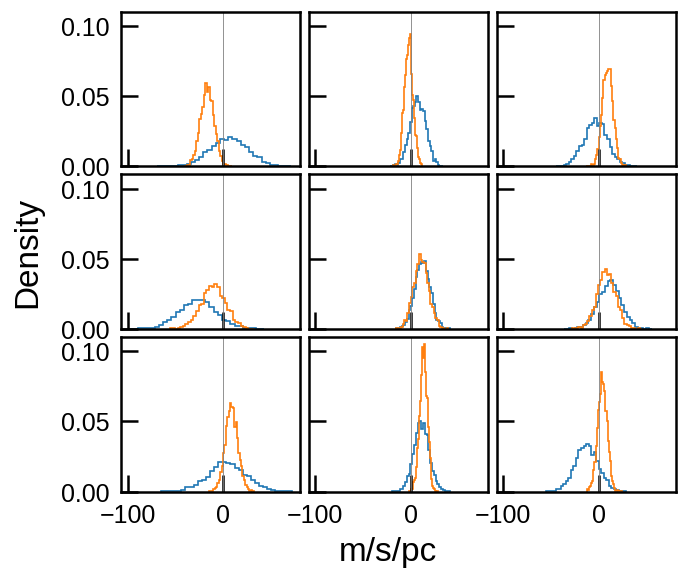

In [433]:
fig, ax = plt.subplots(3, 3, figsize=(6, 5), sharex=True, sharey=True)
fig.subplots_adjust(
    bottom=0.15, top=0.95, right=0.95, left=0.18, hspace=0.05, wspace=0.05
)
ax = ax.ravel()
for cax, cT1, cT2 in zip(
    ax, stanfit["T_param"].reshape((-1, 9)).T, stanfit_hy["T_param"].reshape((-1, 9)).T
):
    cax.hist(cT1, bins=32, density=True, histtype="step")
    cax.hist(cT2, bins=32, density=True, histtype="step")
    cax.axvline(0, c="gray", lw=0.5)
fig.text(0.55, 0.05, "m/s/pc", ha="center", va="center", size=20)
fig.text(0.05, 0.55, "Density", ha="center", va="center", rotation=90, size=20)
# fig.savefig("mock_posterior_T.png")

In [438]:
pd.DataFrame(decompose_T(stanfit['T_param'])).describe()

,omegax,omegay,omegaz,w1,w2,w3,w4,w5,kappa
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.174461,-3.736200,-16.891482,11.064576,0.554909,-9.658413,6.131068,12.099596,1.867577
std,7.364730,11.436398,10.529781,7.136150,11.587977,10.531619,19.401833,8.193046,8.082871
min,-26.730399,-40.223910,-54.530485,-15.905075,-36.798504,-51.426335,-68.789540,-17.058805,-27.319059
25%,-5.171749,-11.220050,-23.844344,6.265720,-7.214364,-16.910373,-7.042843,6.569874,-3.890439
50%,-0.155787,-3.599979,-16.883328,11.190426,0.721397,-9.697106,6.308021,12.097822,1.844222
75%,4.633083,3.692270,-9.757977,15.830815,8.022464,-2.533576,19.385120,17.588782,7.504419
max,24.885897,33.487211,24.747914,33.846505,41.210788,25.054664,70.460264,40.964871,30.139670


In [437]:
pd.DataFrame(decompose_T(stanfit_hy['T_param'])).describe()

,omegax,omegay,omegaz,w1,w2,w3,w4,w5,kappa
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2.548681,0.237989,-4.043061,10.461838,8.997524,-6.366385,-16.645871,10.571279,-0.780331
std,5.547499,4.562876,6.296113,4.990920,3.985940,7.348556,7.064275,7.846946,4.009095
min,-17.771821,-17.088261,-25.535021,-8.575320,-7.293385,-36.069595,-40.822500,-15.741074,-14.631461
25%,-1.157400,-2.758837,-8.035275,7.116405,6.235575,-11.146698,-21.431691,5.250555,-3.542588
50%,2.478349,0.203940,-4.064888,10.436320,8.956960,-6.309922,-16.631941,10.549633,-0.707631
75%,6.345859,3.348042,0.129963,13.810212,11.745479,-1.537121,-11.862142,15.805426,1.875757
max,22.906770,19.927171,17.721489,27.548324,25.356986,16.982203,9.562544,39.094117,13.411676


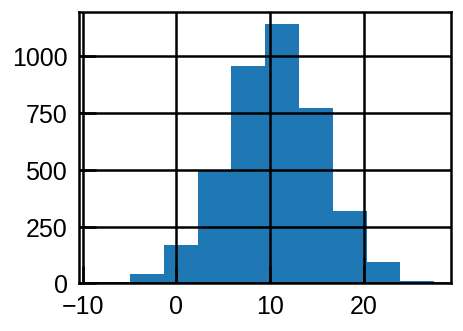

In [445]:
pd.DataFrame(decompose_T(stanfit_hy['T_param']))['w1'].hist()

In [449]:
for col in ['parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr']:
    hy_tails_m19[col] = 0.

In [450]:
%%time
stanfit_tails_m19 = m.fit(hy_tails_m19, b0=b0)  # same b0 for comparison

CPU times: user 7.85 s, sys: 2.19 s, total: 10 s
Wall time: 2min 26s


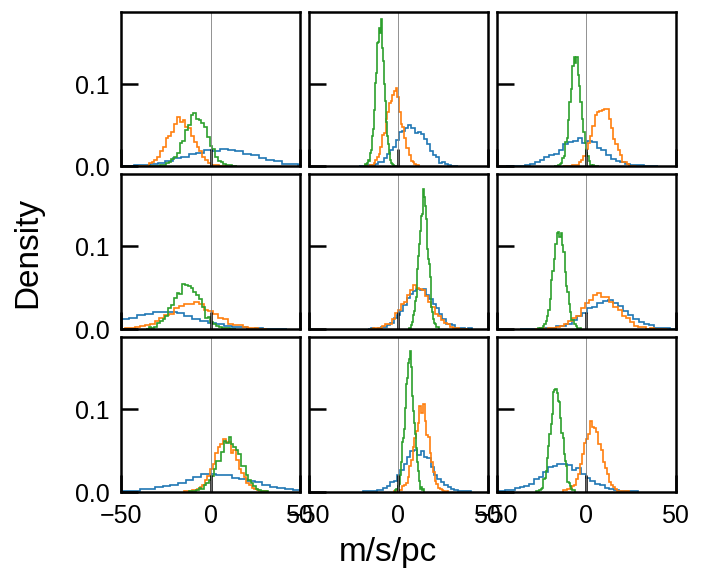

In [452]:
fig, ax = plt.subplots(3, 3, figsize=(6, 5), sharex=True, sharey=True)
fig.subplots_adjust(
    bottom=0.15, top=0.95, right=0.95, left=0.18, hspace=0.05, wspace=0.05
)
ax = ax.ravel()
for cax, cT1, cT2, cT3 in zip(
    ax, stanfit["T_param"].reshape((-1, 9)).T, stanfit_hy["T_param"].reshape((-1, 9)).T, stanfit_tails_m19["T_param"].reshape((-1, 9)).T
):
    cax.hist(cT1, bins=32, density=True, histtype="step")
    cax.hist(cT2, bins=32, density=True, histtype="step")
    cax.hist(cT3, bins=32, density=True, histtype="step")
    cax.axvline(0, c="gray", lw=0.5)
fig.text(0.55, 0.05, "m/s/pc", ha="center", va="center", size=20)
fig.text(0.05, 0.55, "Density", ha="center", va="center", rotation=90, size=20)
# fig.savefig("mock_posterior_T.png")
for cax in ax: cax.set_xlim(-50,50)

In [454]:
azfit_tails_m19 = az.from_pystan(stanfit_tails_m19)
az.summary(azfit_tails_m19, var_names=['v0','sigv','T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.070,0.032,0.001,0.000,-6.133,-6.013,2133.0,2133.0,2137.0,2343.0,1.00
v0[1],45.690,0.038,0.001,0.001,45.617,45.762,2322.0,2322.0,2318.0,2445.0,1.00
v0[2],5.559,0.031,0.001,0.000,5.500,5.619,3129.0,3129.0,3130.0,3285.0,1.00
sigv,0.445,0.014,0.000,0.000,0.419,0.475,3362.0,3355.0,3371.0,3129.0,1.00
"T_param[0,0]",-8.173,6.508,0.197,0.139,-20.782,3.430,1096.0,1096.0,1094.0,1609.0,1.00
"T_param[0,1]",-10.121,2.358,0.061,0.043,-14.347,-5.472,1474.0,1474.0,1473.0,2305.0,1.00
"T_param[0,2]",-5.765,3.056,0.082,0.058,-11.550,-0.152,1383.0,1383.0,1384.0,2035.0,1.00
"T_param[1,0]",-13.186,7.413,0.220,0.155,-27.585,0.420,1139.0,1139.0,1140.0,2045.0,1.00
"T_param[1,1]",14.116,2.572,0.065,0.046,9.149,18.821,1546.0,1546.0,1546.0,2331.0,1.00
"T_param[1,2]",-14.846,3.339,0.089,0.063,-20.764,-8.335,1415.0,1415.0,1418.0,2365.0,1.00


In [453]:
pd.DataFrame(decompose_T(stanfit_tails_m19['T_param'])).describe()

,omegax,omegay,omegaz,w1,w2,w3,w4,w5,kappa
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,10.554866,-8.234287,-1.532160,-4.290912,2.469316,-11.653622,-8.173456,14.115708,-3.561009
std,2.079879,3.729271,3.806577,2.076401,3.484935,3.971753,6.508761,2.572528,2.536510
min,2.078080,-21.629246,-14.093846,-12.212012,-11.316922,-23.863613,-34.167763,5.507535,-12.583742
25%,9.221354,-10.706719,-4.140426,-5.651046,0.204668,-14.289637,-12.397213,12.371069,-5.275935
50%,10.598445,-8.315640,-1.560706,-4.278749,2.449317,-11.562711,-8.205935,14.101360,-3.561325
75%,11.940561,-5.746762,1.089368,-2.902362,4.790888,-8.992280,-3.707517,15.791911,-1.803664
max,19.120567,3.655105,13.304466,3.843969,13.390901,1.020887,14.883603,22.908004,5.367748


In [457]:
hy_corr = hy.copy().g.correct_brightsource_pm()

In [462]:
((hy_corr['pmra']-hy['pmra'])!=0).sum()

176

In [462]:
((hy_corr['pmra']-hy['pmra'])!=0).sum()

176

In [149]:
import astropy.coordinates as coord

c0 = coord.ICRS(x=1,y=0,z=0, representation_type='cartesian').transform_to(coord.Galactic)
c0, c0.cartesian

(<Galactic Coordinate: (l, b, distance) in (deg, deg, )
     (96.33728337, -60.18855195, 1.)>,
 <CartesianRepresentation (x, y, z) [dimensionless]
     (-0.05487566, 0.49410944, -0.86766614)>)

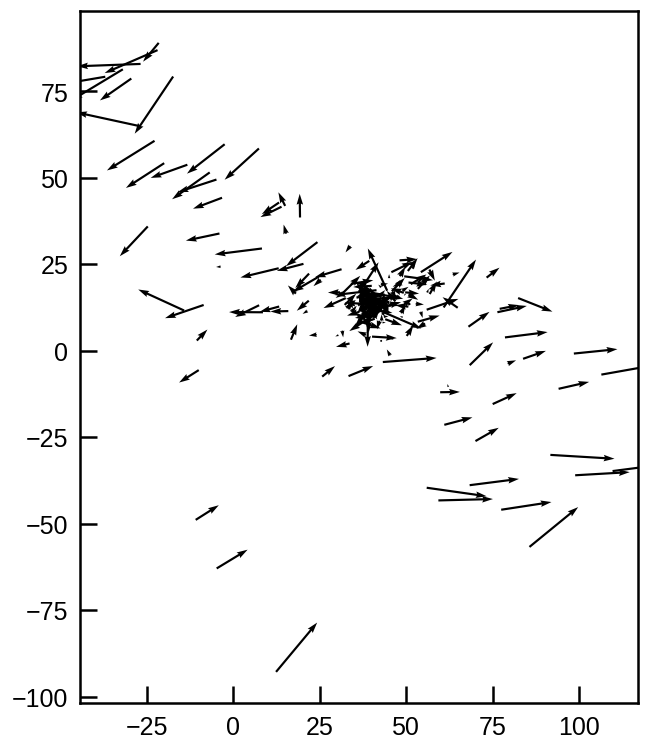

In [152]:
c = hy_tails_m19.g.icrs
plt.figure(figsize=(6,8))
plt.axes(aspect='equal')
plt.quiver(c.cartesian.y.value, c.cartesian.z.value,
           c.velocity.d_y.value-np.median(c.velocity.d_y.value),
           c.velocity.d_z.value-np.median(c.velocity.d_z.value))

In [183]:
hp.nside2npix(2**4), hp.nside2pixarea(2**4,degrees=True)

(3072, 13.428698323378669)